<a href="https://colab.research.google.com/github/akshaygrao77/DeepLearning-Assignment3/blob/main/Coding_Assignment_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install matplotlib==3.5.0

In [2]:
!apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [3]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML 
np.random.seed(0)

In [4]:
def get_gaussian_distribution_with_sd(std_dev):
  def get_reward_from_gaussian_distribution(mean):
    return np.random.normal(loc=mean, scale=std_dev),str('Gaussian(mean=')+str(mean)+',std='+str(std_dev)+')'
  return get_reward_from_gaussian_distribution

In [5]:
def get_uniform_distribution_with_sd(width):
  def get_reward_from_uniform_distribution(mean):
    return np.random.uniform(low=mean-(width / 2),high=mean + (width/2)),str('Uniform(width=')+str(width)+', mean='+str(mean)+')'
  return get_reward_from_uniform_distribution

In [6]:
def get_reward_from_bernoulli_distribution(prob):
  return np.random.binomial(n=1, p=prob),str('Bernoulli (p=')+str(prob)+')'

In [7]:
class BasicArmNode:
    # Basic arm structure which can be extended for UCB

  def __init__(self, true_mean_reward,reward_distribution=None):                
    self.true_mean_reward = true_mean_reward      # the true reward value(act as if, unknown)         
    self.initialize() # reset the arm state
    self.reward_distribution = reward_distribution
        
  def initialize(self):
    self.sample_mean_reward = 0   # the sample mean estimate for reward              
    self.play_count = 0   # the number of times this arm was played
    
  def play_arm_sample_reward_update_values(self):
    reward = 0
    
    if(self.reward_distribution is None):
      # the reward is a gaussian distribution with unit variance around the true mean reward
      reward = np.random.randn() + self.true_mean_reward
    else:
      reward,_ = self.reward_distribution(self.true_mean_reward)
    
    self.play_count += 1

    # Compute sample mean reward from reward which was sampled from distribution
    self.sample_mean_reward = (1 - 1.0/self.play_count) * self.sample_mean_reward + (1.0/self.play_count) * reward

    return reward
    
  def get_estimate(self): # ETC returns mean whereas UCB returns its own estimate of this arm
    return self.sample_mean_reward

In [8]:
class BasicBanditFramework:
  def __init__(self, arm_true_mean_reward_list,arm=BasicArmNode,reward_distribution=None,is_record_stats=False):
    self.arms = [arm(true_m_reward,reward_distribution) for true_m_reward in arm_true_mean_reward_list]
    self.number_of_arms = len(arm_true_mean_reward_list)
    self.reward_distribution = reward_distribution
    self.is_record_stats = is_record_stats

    if(self.is_record_stats):
      self.optimal_arm_index = np.argmax(np.array(arm_true_mean_reward_list))
  
  def initialize_run(self, number_of_steps):
    """ reset counters at the start of a run """
        
    # save the number of steps over which the run will take place
    self.number_of_steps = number_of_steps
        
    # monitor the total reward obtained over the run
    self.total_reward = 0

    # monitor the total regret obtained over the run
    self.total_regret = 0
        
    # the current total reward at each timestep of the run
    self.total_reward_per_timestep = []
        
    # the actual reward obtained at each timestep
    self.reward_per_timestep = []
           
    # stats for each time-step
    # - by default records: estimate, number of trials
    self.arm_stats = np.zeros(shape=(number_of_steps+1, 
                                      self.number_of_arms, 
                                      2))
        
    # ensure that all arms are re-initialized
    for arm in self.arms: arm.initialize()
  
  def initialize_record_simulation(self,number_of_steps):
    # keep track of the average values over the run
    self.total_reward_mean_over_simulations = 0
    self.total_regret_mean_over_simulations = 0
    self.mean_total_reward = 0
    self.optimal_selected = 0
    self.arm_percentages_overall = np.zeros(self.number_of_arms)   
    self.estimates = np.zeros(shape=(number_of_steps+1,self.number_of_arms))
        
    # the cumulative total reward per timestep
    self.cumulative_reward_per_round = np.zeros(shape=(number_of_steps))
        
    # the actual reward obtained at each timestep
    self.mean_reward_per_round = np.zeros(shape=(number_of_steps))

    
  def play_arm_and_update(self,arm_index):
    reward = self.arms[arm_index].play_arm_sample_reward_update_values()
    if(self.is_record_stats):
      # update the total reward
      self.total_reward += reward   

      optimal_arm_reward = self.arms[self.optimal_arm_index].true_mean_reward
      regret = optimal_arm_reward - reward
      self.total_regret += regret
        
      # store the current total reward at this timestep
      self.total_reward_per_timestep.append(self.total_reward)
        
      # store the reward obtained at this timestep
      self.reward_per_timestep.append(reward) 
    
    return reward
        
  def select_best_arm(self ):
    arm_index = np.argmax([each_arm.get_estimate() for each_arm in self.arms]) 
    return arm_index
  
  def get_arm_stats( self ):
    """ get the current information from each arm """        
    arm_stats = [[each_arm.sample_mean_reward, each_arm.play_count] for each_arm in self.arms]
    return arm_stats

  def get_mean_reward( self ):
    """ the total reward averaged over the number of time steps """
    return (self.total_reward/self.number_of_steps)
    
  def get_total_reward_per_timestep( self ):
    """ the cumulative total reward at each timestep of the run """
    return self.total_reward_per_timestep
    
  def get_reward_per_timestep( self ):
    """ the actual reward obtained at each timestep of the run """
    return self.reward_per_timestep
    
  def get_estimates(self):
    """ get the estimate of each arm's reward at each timestep of the run """
    return self.arm_stats[:,:,0]  
    
  def get_number_of_trials(self):
    """ get the number of trials of each arm at each timestep of the run """
    return self.arm_stats[:,:,1]          
                
  def get_arm_percentages( self ):
    """ get the percentage of times each arm was tried over the run """
    return (self.arm_stats[:,:,1][self.number_of_steps]/self.number_of_steps)    
    
  def get_optimal_arm_percentage( self ):
    """ get the percentage of times the optimal arm was tried """        
    final_trials = self.arm_stats[:,:,1][self.number_of_steps]
    return (final_trials[self.optimal_arm_index]/self.number_of_steps)

  def reset_all_arms(self):
    for each_arm in self.arms:
      each_arm.initialize()
    
  def run( self, number_of_steps ):  
    arms_selected = []
    reward_of_selected_arms = []
    for t in range(number_of_steps):                               
      arm_index = self.select_best_arm() 
      print("Best arm",arm_index)
      arms_selected.append(arm_index)
      reward_per_step = self.play_arm_and_update(arm_index)
      print("reward per step",reward_per_step)
      reward_of_selected_arms.append(reward_per_step)
    
    return arms_selected,reward_of_selected_arms
  
  def update_mean( self, current_mean, new_value, n ):
    """ calculate the new mean from the previous mean and the new value """
    return (1 - 1.0/n) * current_mean + (1.0/n) * new_value

  def update_mean_array( self, current_mean, new_value, n ):
    """ calculate the new mean from the previous mean and the new value for an array """

    new_value = np.array(new_value)
        
    # pad the new array with its last value to make sure its the same length as the original           
    pad_length = (current_mean.shape[0] - new_value.shape[0])               
        
    if pad_length > 0:
      new_array = np.pad(new_value,(0,pad_length), mode='constant', constant_values=new_value[-1])
    else:
      new_array = new_value
    
    return (1 - 1.0/n) * current_mean + (1.0/n) * new_array
        
  def record_test_stats(self,simulation_number):
    """ update the mean value for each statistic being tracked over a run """
    
    # calculate the new means from the old means and the new value
    self.total_reward_mean_over_simulations = self.update_mean( self.total_reward_mean_over_simulations, self.total_reward, simulation_number)
    self.total_regret_mean_over_simulations = self.update_mean( self.total_regret_mean_over_simulations, self.total_regret, simulation_number)
    self.mean_total_reward = self.update_mean( self.mean_total_reward, self.get_mean_reward(), simulation_number)
    self.optimal_selected = self.update_mean( self.optimal_selected, self.get_optimal_arm_percentage(), simulation_number)
    self.arm_percentages_overall = self.update_mean( self.arm_percentages_overall, self.get_arm_percentages(), simulation_number)        
        
    self.cumulative_reward_per_round = self.update_mean_array( self.cumulative_reward_per_round, 
                                                                      self.get_total_reward_per_timestep(), simulation_number)        
    self.estimates = self.update_mean_array( self.estimates, self.get_estimates(), simulation_number)
    self.mean_reward_per_round = self.update_mean_array( self.mean_reward_per_round, self.get_reward_per_timestep(), simulation_number)

In [9]:
arm_true_mean_reward_list=[30,15,45]
basicBanditFrame = BasicBanditFramework(arm_true_mean_reward_list)
arms_selected,reward_selected = basicBanditFrame.run(1)
print("Arms selected: ",arms_selected) 
print(" Reward per step: ",reward_selected)

Best arm 0
reward per step 31.764052345967663
Arms selected:  [0]
 Reward per step:  [31.764052345967663]


In [10]:
class UCBArmNode(BasicArmNode):
  def __init__( self,true_mean_reward,reward_distribution=None):  
    super().__init__(true_mean_reward,reward_distribution)
  
  def get_estimate(self,round_number,ucbType='1_by_n^2',horizon=None): # UCB computes UCB value
    if(self.play_count == 0):
      return float('inf') 
    
    if(ucbType == 'horizon_based_delta'):
      ucb_value = self.sample_mean_reward + (np.sqrt(2 * np.log(horizon * horizon) / self.play_count))
      return ucb_value
    elif(ucbType == 'round_based'):
      ucb_value = self.sample_mean_reward + (np.sqrt(2 * np.log(1 + round_number * math.pow(np.log(round_number),2)) / self.play_count))
      return ucb_value

In [11]:
def get_number_of_rounds_in_doubling_trick(horizon):
  dim_horizon = 0
  h = 1
  interval = 0
  for rn in range(1,horizon+1):
    h =(int) (h + interval)
    interval = math.pow(2,rn)
    dim_horizon += h
  return dim_horizon

In [12]:
class UCBBanditAlgo(BasicBanditFramework):
  def __init__(self, arm_true_mean_reward_list,arm=UCBArmNode,reward_distribution=None,is_record_stats=False): 
    super().__init__(arm_true_mean_reward_list,arm,reward_distribution,is_record_stats)
  
  def select_best_arm(self,round_number,ucbType,horizon):
    ucb_values_of_all_arms = [each_arm.get_estimate(round_number,ucbType,horizon) for each_arm in self.arms]
    # print("UCB at round: ",round_number," is:: ", ucb_values_of_all_arms)
    arm_index = np.argmax(ucb_values_of_all_arms) 
    return arm_index 
    
  def run( self, horizon,ucbType):
    if(self.is_record_stats):
      self.initialize_run(horizon)
    arms_selected = []
    reward_of_selected_arms = []
    for round_number in range(1,horizon+1):
      if(self.is_record_stats):
        # get information about all arms at the start of the time step
        self.arm_stats[round_number] = self.get_arm_stats()
      arm_index = self.select_best_arm(round_number,ucbType,horizon) 
      # print("Best arm",arm_index)
      arms_selected.append(arm_index)
      reward_per_round = self.play_arm_and_update(arm_index)
      # print("reward per step",reward_per_round)
      reward_of_selected_arms.append(reward_per_round)
    
    if(self.is_record_stats):
      # get information about all arms at the end
      self.arm_stats[horizon] = self.get_arm_stats()

    return arms_selected,reward_of_selected_arms

  def run_doubling_trick(self,number_of_rounds):
    arms_selected = []
    reward_of_selected_arms = []
    horizon = 1
    interval = 0
    sc = 0
    total_number_of_rounds = get_number_of_rounds_in_doubling_trick(number_of_rounds)
    if(self.is_record_stats):
      self.initialize_run(total_number_of_rounds)
    
    for rn in range(1,number_of_rounds+1):
      self.reset_all_arms()
      horizon =(int) (horizon + interval)
      interval = math.pow(2,rn)
      for round_number in range(1,horizon+1):
        sc += 1
        arm_index = self.select_best_arm(round_number,'horizon_based_delta',horizon) 
        # print("Best arm",arm_index)
        arms_selected.append(arm_index)
        reward_per_round = self.play_arm_and_update(arm_index)
        # print("reward per step",reward_per_round)
        reward_of_selected_arms.append(reward_per_round)
        if(self.is_record_stats):
          # get information about all arms at the start of the time step
          self.arm_stats[sc] = self.get_arm_stats()
    
    return arms_selected,reward_of_selected_arms
  
  def run_simulations( self,number_of_simulations, horizon,ucbType):
    if(ucbType == 'doubling_trick'):
      dim_horizon = get_number_of_rounds_in_doubling_trick(horizon)
    else:
      dim_horizon = horizon
    
    if(self.is_record_stats):
      self.initialize_record_simulation(dim_horizon)
    
    # arms_selected_overall = np.zeros(shape=(number_of_simulations,dim_horizon))
    # reward_selected_overall = np.zeros(shape=(number_of_simulations,dim_horizon))
    for each_simulation in range(1,number_of_simulations+1):
      if(self.is_record_stats):
        self.initialize_run(dim_horizon)
      if(ucbType == 'doubling_trick'):
        arms_selected,reward_selected = self.run_doubling_trick(horizon)
      else:
        arms_selected,reward_selected = self.run(horizon,ucbType)
      if(self.is_record_stats):
        self.record_test_stats(each_simulation)
      # arms_selected_overall[each_simulation] = np.array(arms_selected)
      # reward_selected_overall[each_simulation] = np.array(reward_selected)
    
    # mean_reward_per_round = np.mean(reward_selected_overall,axis=0)

    # return arms_selected_overall.astype(int),reward_selected_overall,mean_reward_per_round
    
    return self


In [13]:
class ThompsonArmNode(BasicArmNode):
  def __init__( self,true_mean_reward,reward_distribution=None):  
    super().__init__(true_mean_reward,reward_distribution)

  def initialize_prior_distribution(self,prior_distribution_name,prior_initial_parameter_dict):
    self.prior_distribution_name = prior_distribution_name
    self.prior_parameter_dict = prior_initial_parameter_dict
    if(self.prior_distribution_name == "GAUSSIAN_KNOWN_VARIANCE"):
      self.reward_earned_list = []

  
  # Samples from prior distribution and returns sampled value
  def get_estimate(self):
    if(self.prior_distribution_name == "BETA"):
      return np.random.beta(a=self.prior_parameter_dict['alpha'],b=self.prior_parameter_dict['beta'])
    elif(self.prior_distribution_name == "GAUSSIAN_KNOWN_VARIANCE"):
      std_dev = 1 / math.sqrt(self.prior_parameter_dict['precision'])
      return np.random.normal(loc=self.prior_parameter_dict['mean'], scale=std_dev)
  
  def update_prior_distribution_parameters(self,reward):
    if(self.prior_distribution_name == "BETA"):
      if(reward == 1):
        self.prior_parameter_dict['alpha'] = self.prior_parameter_dict['alpha'] + 1
      elif(reward == 0):
        self.prior_parameter_dict['beta'] = self.prior_parameter_dict['beta'] + 1
      else:
        print("Reward invalid for beta prior updation. Obtained reward was:"+str(reward))
        raise Exception("Reward invalid for beta prior updation. Obtained reward was:"+str(reward))
    elif(self.prior_distribution_name == "GAUSSIAN_KNOWN_VARIANCE"):
      self.reward_earned_list.append(reward)
      tou = self.prior_parameter_dict['known_precision']
      mean = self.prior_parameter_dict['mean']
      t_0 = self.prior_parameter_dict['precision']
      # update the mean of the posterior      
      self.prior_parameter_dict['mean'] = ((t_0 * mean) + (tou * np.array(self.reward_earned_list).sum()))/(t_0 + (self.play_count * tou))     
      # increase the sum of all precisions
      self.prior_parameter_dict['precision'] = t_0 + (self.play_count * tou)
  
  def play_arm_sample_reward_update_values(self):
    reward = super().play_arm_sample_reward_update_values()
    self.update_prior_distribution_parameters(reward)

    return reward


In [14]:
class ThomposonSamplingBanditAlgo(BasicBanditFramework):
  def __init__(self, arm_true_mean_reward_list,prior_distribution_name,prior_initial_parameter_dict,arm=ThompsonArmNode,reward_distribution=None,is_record_stats=False): 
    super().__init__(arm_true_mean_reward_list,arm,reward_distribution,is_record_stats)
    for each_arm in self.arms:
      each_arm.initialize_prior_distribution(prior_distribution_name,prior_initial_parameter_dict)
  
  def select_best_arm(self,round_number):
    sampled_values_from_prior_distribution = [each_arm.get_estimate() for each_arm in self.arms]
    # print("Sampled values at round: ",round_number," is:: ", sampled_values_from_prior_distribution)
    arm_index = np.argmax(sampled_values_from_prior_distribution) 
    return arm_index 
    
  def run(self, horizon):
    if(self.is_record_stats):
      self.initialize_run(horizon)
    arms_selected = []
    reward_of_selected_arms = []
    for round_number in range(1,horizon+1):
      if(self.is_record_stats):
        # get information about all arms at the start of the time step
        self.arm_stats[round_number] = self.get_arm_stats()
      arm_index = self.select_best_arm(round_number) 
      # print("Best arm",arm_index)
      arms_selected.append(arm_index)
      
      reward_per_round = self.play_arm_and_update(arm_index)
      # print("reward per step",reward_per_round)
      reward_of_selected_arms.append(reward_per_round)
    
    if(self.is_record_stats):
      # get information about all arms at the end
      self.arm_stats[horizon] = self.get_arm_stats()

    return arms_selected,reward_of_selected_arms
  
  def run_simulations( self,number_of_simulations, horizon):
    if(self.is_record_stats):
      self.initialize_record_simulation(horizon)

    for each_simulation in range(1,number_of_simulations+1):
      if(self.is_record_stats):
        self.initialize_run(horizon)

      arms_selected,reward_selected = self.run(horizon)
      if(self.is_record_stats):
        self.record_test_stats(each_simulation)
    
    return self

In [15]:
class ETCBanditAlgo(BasicBanditFramework):
  def __init__(self, arm_true_mean_reward_list,arm=BasicArmNode,reward_distribution=None,is_record_stats=False): 
    super().__init__(arm_true_mean_reward_list,arm,reward_distribution,is_record_stats)
    
  def get_optimal_explore_round_per_arm_from_DELTA( self, number_of_rounds,sub_optimality_gap):
    optimal_explore_round_per_arm = max([1,math.ceil((4/math.pow(sub_optimality_gap,2))*np.log((number_of_rounds*math.pow(sub_optimality_gap,2))/4) )])
    return optimal_explore_round_per_arm
  
  def filter_arms_for_successive_elimination(self,active_arm_indices,alpha_t):
    p_max = 0
    for each_active_index in active_arm_indices:
      current_p = self.arms[each_active_index].sample_mean_reward
      if(current_p > p_max):
        p_max = current_p
    
    new_active_arm_indices = []
    for each_active_index in active_arm_indices:
      current_p = self.arms[each_active_index].sample_mean_reward
      if(p_max - current_p < 2 * alpha_t):
        new_active_arm_indices.append(each_active_index)
    
    return new_active_arm_indices

  # Doesn't work because it is for k=2 case
  # def get_optimal_explore_round_per_arm_without_DELTA( self, number_of_rounds):
  #   optimal_explore_round_per_arm = max([1,math.ceil(math.pow(number_of_rounds,(2/3))*math.pow((2*math.log(2*number_of_rounds)),(1/3)))])
  #   return optimal_explore_round_per_arm
  
  def set_optimal_explore_round_per_arm_from_DELTA(self,opt):
    self.optimal_explore_round_per_arm = opt

  def run( self, number_of_rounds,explore_round_per_arm):
    if(self.is_record_stats):
      self.initialize_run(number_of_rounds)
    arms_selected = []
    reward_of_selected_arms = []
    number_of_arms = len(self.arms)
    sc = 0
    for each_arm in range(number_of_arms):
      for each_explore_per_arm in range(explore_round_per_arm):
        if(self.is_record_stats):
          sc += 1
          # get information about all arms at the start of the time step
          self.arm_stats[sc] = self.get_arm_stats() 
        arms_selected.append(each_arm)
        reward_of_selected_arms.append(self.play_arm_and_update(each_arm))
    
    number_of_exploitation_rounds = number_of_rounds - number_of_arms * explore_round_per_arm
    best_arm_index = self.select_best_arm()

    for each_exploitation in range(number_of_exploitation_rounds):
      if(self.is_record_stats):
        sc += 1
        # get information about all arms at the start of the time step
        self.arm_stats[sc] = self.get_arm_stats()  
      arms_selected.append(best_arm_index)
      reward_of_selected_arms.append(self.play_arm_and_update(best_arm_index))
    
    return arms_selected,reward_of_selected_arms,explore_round_per_arm

  def run_with_successive_elimination(self,number_of_rounds):
    small_delta = 1/number_of_rounds
    if(self.is_record_stats):
      self.initialize_run(number_of_rounds)
    arms_selected = []
    reward_of_selected_arms = []
    sc = 0
    phase_count = 0
    active_arm_indices = []
    exit_while = False
    while(not(exit_while)):
      if(phase_count == 0):
        # When we start all arms are in active set
        active_arm_indices = [i for i in range(len(self.arms))]
      else:
        alpha_t = math.sqrt(math.log((number_of_rounds*math.pow(phase_count,2)) / small_delta)/phase_count)
        active_arm_indices = self.filter_arms_for_successive_elimination(active_arm_indices,alpha_t)
      
      for each_active_arm_index in active_arm_indices:
        if(self.is_record_stats):
          sc += 1
          # get information about all arms at the start of the time step
          self.arm_stats[sc] = self.get_arm_stats()  
        arms_selected.append(each_active_arm_index)
        reward_of_selected_arms.append(self.play_arm_and_update(each_active_arm_index))
        if(sc == number_of_rounds):
          exit_while = True
          break
      phase_count = phase_count + 1
    
    return arms_selected,reward_of_selected_arms

  def run_simulations( self,number_of_simulations, number_of_rounds,explore_per_arm=None):
    if(self.is_record_stats):
      self.initialize_record_simulation(number_of_rounds)

    # arms_selected_overall = np.zeros(shape=(number_of_simulations,number_of_rounds))
    # reward_selected_overall = np.zeros(shape=(number_of_simulations,number_of_rounds))
    for each_simulation in range(1,number_of_simulations+1):
      self.reset_all_arms()
      if(explore_per_arm is None):
        arms_selected,reward_of_selected_arms = self.run_with_successive_elimination(number_of_rounds)
        self.optimal_explore_round_per_arm = explore_per_arm
      else:
        arms_selected,reward_of_selected_arms,explore_round_per_arm = self.run(number_of_rounds,explore_per_arm)
      
      if(self.is_record_stats):
        self.record_test_stats(each_simulation)
      # arms_selected_overall[each_simulation] = np.array(arms_selected)
      # reward_selected_overall[each_simulation] = np.array(reward_of_selected_arms)
    
    # mean_reward_per_round = np.mean(reward_selected_overall,axis=0)

    # return arms_selected_overall.astype(int),reward_selected_overall,mean_reward_per_round,explore_per_arm

    return self


Answer for: **ETC knowing gap Delta (for this k =2)**

In [16]:
def etc_algo_with_known_gap_with_two_arms(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=None,is_record_stats=False):
  sub_optimality_gap = abs(arm_true_mean_reward_list[1] - arm_true_mean_reward_list[0])
  etcBanditAlgo = ETCBanditAlgo(arm_true_mean_reward_list,reward_distribution=reward_distribution,is_record_stats=is_record_stats)
  optimal_explore_round_per_arm = etcBanditAlgo.get_optimal_explore_round_per_arm_from_DELTA(number_of_rounds ,sub_optimality_gap)
  returnObj = etcBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,optimal_explore_round_per_arm)
  returnObj.set_optimal_explore_round_per_arm_from_DELTA(optimal_explore_round_per_arm)
  # arms_selected_overall,reward_selected_overall,mean_reward_per_round,explore_per_arm = etcBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,optimal_explore_round_per_arm)
  # most_frequent_arms_selected = get_most_frequent_action_per_round(arms_selected_overall)
  return returnObj
  # return arms_selected_overall,reward_selected_overall,mean_reward_per_round,most_frequent_arms_selected,optimal_explore_round_per_arm

Answer for: **ETC without knowing Delta (for this k>2)**

The optimal m* derived in class with unknown suboptimality gap is only for k=2 case.   
In general if suboptimality gap is unknown then the number of
plays before commitment can be made data dependent. The following algortihm will be used: (taken from paper **PAC bounds for mult-armed bandits and markov decision processes - Eyal Even-dar, shie mannor, yishay mansour**) (https://jmlr.csail.mit.edu/papers/volume7/evendar06a/evendar06a.pdf)

**Input** : δ > 0   
**Output** : An arm   
Set t = 1 and S = A;   
Set for every arm a: $\hat{p}_{a}^{1}=0$    
Sample every arm $a \in S$ once and let $\hat{p}_{a}^{t}$ be the average reward of arm a by time t;   
**repeat**   
  Let $\hat{p}_{max}^{t} = max_{a \in S}\hat{p}_{a}^{t} $ and $ \alpha_{t} = \sqrt{\ln (cnt^{2}/δ)}$, where c is a constant;

**foreach** arm $a ∈ S$ such that $\hat{p}_{max}^{t} - \hat{p}_{a}^{t} \geqslant 2αt $ do,   
      set S = S \ {a};   
      **end**   
t = t +1;   
**until** |S| > 1;


For our usage, loop runs until horizon instead of condition "|S| > 1"


In [17]:
def etc_algo_unknown_gap(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=None,is_record_stats=False):
  etcBanditAlgo = ETCBanditAlgo(arm_true_mean_reward_list,reward_distribution=reward_distribution,is_record_stats=is_record_stats)
  returnObj = etcBanditAlgo.run_simulations(number_of_simulations,number_of_rounds)
  # arms_selected_overall,reward_selected_overall,mean_reward_per_round,explore_per_arm = etcBanditAlgo.run_simulations(number_of_simulations,number_of_rounds)
  # most_frequent_arms_selected = get_most_frequent_action_per_round(arms_selected_overall)
  return returnObj
  # return arms_selected_overall,reward_selected_overall,mean_reward_per_round,most_frequent_arms_selected,explore_per_arm  

Answer for: **UCB with horizon known derived in class(i.e, probability of failure $\delta = 1/n^{2}$)**

In [18]:
def ucb_known_horizon_1_by_n2(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=None,is_record_stats=False):
  ucbBanditAlgo = UCBBanditAlgo(arm_true_mean_reward_list,reward_distribution=reward_distribution,is_record_stats=is_record_stats)
  returnObj = ucbBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,'horizon_based_delta')
  # arms_selected_overall,reward_selected_overall,mean_reward_per_round = ucbBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,'horizon_based_delta')
  # most_frequent_arms_selected = get_most_frequent_action_per_round(arms_selected_overall)
  return returnObj
  # return arms_selected_overall,reward_selected_overall,mean_reward_per_round,most_frequent_arms_selected  

Answer for: **Same UCB in the above case but with an unknown horizon using the doubling trick.**

In [19]:
def ucb_unknown_horizon_doubling_trick(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=None,is_record_stats=False):
  ucbBanditAlgo = UCBBanditAlgo(arm_true_mean_reward_list,reward_distribution=reward_distribution,is_record_stats=is_record_stats)
  returnObj = ucbBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,'doubling_trick')
  # arms_selected_overall,reward_selected_overall,mean_reward_per_round = ucbBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,'doubling_trick')
  # most_frequent_arms_selected = get_most_frequent_action_per_round(arms_selected_overall)
  return returnObj
  # return arms_selected_overall,reward_selected_overall,mean_reward_per_round,most_frequent_arms_selected  

Answer for : **UCB in Chapter 8**

In [20]:
def ucb_known_horizon_chap8(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=None,is_record_stats=False):
  ucbBanditAlgo = UCBBanditAlgo(arm_true_mean_reward_list,reward_distribution=reward_distribution,is_record_stats=is_record_stats)
  returnObj = ucbBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,'round_based')
  # arms_selected_overall,reward_selected_overall,mean_reward_per_round = ucbBanditAlgo.run_simulations(number_of_simulations,number_of_rounds,'round_based')
  # most_frequent_arms_selected = get_most_frequent_action_per_round(arms_selected_overall)
  return returnObj
  # return arms_selected_overall,reward_selected_overall,mean_reward_per_round,most_frequent_arms_selected  

Answer for: **Thompson sampling call**

In [21]:
def thompson_sampling_algo(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,prior_distribution_name,prior_initial_parameter_dict,reward_distribution=None,is_record_stats=False):
  thompsonSamplingBanditAlgo = ThomposonSamplingBanditAlgo(arm_true_mean_reward_list,prior_distribution_name,prior_initial_parameter_dict,reward_distribution=reward_distribution,is_record_stats=is_record_stats)
  returnObj = thompsonSamplingBanditAlgo.run_simulations(number_of_simulations,number_of_rounds)
  return returnObj

In [22]:
arm_true_mean_reward_list=[28,28.5]
etc_algo_with_known_gap_with_two_armsObj = etc_algo_with_known_gap_with_two_arms(arm_true_mean_reward_list,1000,27,is_record_stats=True)
print("Cumulative reward per round: ",etc_algo_with_known_gap_with_two_armsObj.cumulative_reward_per_round)
print("Arms selection percentages: ",etc_algo_with_known_gap_with_two_armsObj.arm_percentages_overall)
print("Optimal arm selection: ",etc_algo_with_known_gap_with_two_armsObj.optimal_selected)
print("Mean reward per round: ",etc_algo_with_known_gap_with_two_armsObj.mean_reward_per_round)
print("Mean total reward per round: ",etc_algo_with_known_gap_with_two_armsObj.mean_total_reward)
print("Mean total reward per simulation: ",etc_algo_with_known_gap_with_two_armsObj.total_reward_mean_over_simulations)
print("Optimal explore per round: ",etc_algo_with_known_gap_with_two_armsObj.optimal_explore_round_per_arm)
print("Mean total regret per simulation: ",etc_algo_with_known_gap_with_two_armsObj.total_regret_mean_over_simulations)

Cumulative reward per round:  [ 28.03096747  56.07653622  84.0739336  112.11251563 140.08348033
 168.12220081 196.07025963 224.04597293 252.08089669 280.60484034
 309.10940508 337.52345042 365.98231306 394.45523302 422.93605203
 451.45991191 479.9322022  508.43869291 536.89673159 565.32641052
 593.77095223 622.16730973 650.59715116 679.01386926 707.43076866
 735.87121267 764.25699358]
Arms selection percentages:  [0.37807407 0.58488889]
Optimal arm selection:  0.5848888888888899
Mean reward per round:  [28.03096747 28.04556874 27.99739739 28.03858203 27.9709647  28.03872048
 27.94805882 27.9757133  28.03492377 28.52394365 28.50456473 28.41404534
 28.45886264 28.47291996 28.48081901 28.52385988 28.47229028 28.50649071
 28.45803868 28.42967893 28.44454172 28.3963575  28.42984143 28.4167181
 28.4168994  28.44044402 28.3857809 ]
Mean total reward per round:  28.305814576880582
Mean total reward per simulation:  764.2569935757759
Optimal explore per round:  9
Mean total regret per simulatio

In [23]:
arm_true_mean_reward_list=[4,5,5.5,6]
# arm_true_mean_reward_list=[30,28]
etc_algo_unknown_gapObj = etc_algo_unknown_gap(arm_true_mean_reward_list,1000,120,is_record_stats=True)
print("Cumulative reward per round: ",etc_algo_unknown_gapObj.cumulative_reward_per_round)
print("Arms selection percentages: ",etc_algo_unknown_gapObj.arm_percentages_overall)
print("Optimal arm selection: ",etc_algo_unknown_gapObj.optimal_selected)
print("Mean reward per round: ",etc_algo_unknown_gapObj.mean_reward_per_round)
print("Mean total reward per round: ",etc_algo_unknown_gapObj.mean_total_reward)
print("Mean total reward per simulation: ",etc_algo_unknown_gapObj.total_reward_mean_over_simulations)
print("Mean total regret per simulation: ",etc_algo_unknown_gapObj.total_regret_mean_over_simulations)

Cumulative reward per round:  [  4.05430913   9.11447722  14.60079368  20.59299735  24.59232123
  29.60175868  35.15992969  41.20247426  45.23995302  50.23273653
  55.7478848   61.76336651  65.78685829  70.77522323  76.31960582
  82.29399791  86.29961925  91.26732473  96.75710962 102.76810918
 106.80580309 111.84344581 117.36531201 123.29668649 127.35016389
 132.42434891 137.98116421 143.9665181  148.11601757 153.16495794
 158.70467643 164.63518531 168.75998221 173.84598169 179.37627891
 185.24971247 189.51615624 194.59742445 200.08773909 205.94878955
 210.30020422 215.4615935  220.90027953 226.78870826 231.23280888
 236.38978999 241.89735117 247.70730809 252.25803903 257.40375468
 262.86849621 268.7219039  273.27504289 278.47868537 284.01699909
 289.7189664  294.42707695 299.72320777 305.27400414 310.97607327
 315.71194474 321.00778312 326.49457297 332.26507437 337.13226282
 342.4311478  347.97393933 353.71856516 358.70129811 364.10143269
 369.62240759 375.27337081 380.37283928 385.69

In [24]:
arm_true_mean_reward_list=[4,5,5.5,6]
# arm_true_mean_reward_list=[30,28]
ucb_known_horizon_1_by_n2Obj = ucb_known_horizon_1_by_n2(arm_true_mean_reward_list,1000,120,is_record_stats=True)
print("Cumulative reward per round: ",ucb_known_horizon_1_by_n2Obj.cumulative_reward_per_round)
print("Arms selection percentages: ",ucb_known_horizon_1_by_n2Obj.arm_percentages_overall)
print("Optimal arm selection: ",ucb_known_horizon_1_by_n2Obj.optimal_selected)
print("Mean reward per round: ",ucb_known_horizon_1_by_n2Obj.mean_reward_per_round)
print("Mean total reward per round: ",ucb_known_horizon_1_by_n2Obj.mean_total_reward)
print("Mean total reward per simulation: ",ucb_known_horizon_1_by_n2Obj.total_reward_mean_over_simulations)
print("Mean total regret per simulation: ",ucb_known_horizon_1_by_n2Obj.total_regret_mean_over_simulations)

Cumulative reward per round:  [  4.02651999   8.99874318  14.45950076  20.43744596  26.08359246
  31.61887216  37.10020734  42.58240425  47.97099861  53.38417461
  58.96741309  64.50806217  70.07116227  75.66431174  81.26629053
  86.83241819  92.43977679  98.08786793 103.69003743 109.38126716
 115.02871651 120.65274472 126.23884407 131.91044879 137.57745636
 143.26537619 148.91211736 154.56469571 160.28679261 165.93164479
 171.66676168 177.36483114 183.11725105 188.808438   194.53112519
 200.22301923 205.96741084 211.72818667 217.51639008 223.23313
 229.01881145 234.8117143  240.53863938 246.30916653 252.11884856
 257.87558139 263.7089873  269.47745011 275.30278798 281.03616412
 286.84078496 292.622805   298.40116757 304.18148704 310.00671345
 315.836676   321.64440752 327.40920567 333.24996285 338.97507729
 344.78995924 350.64437228 356.44339909 362.30090472 368.15103935
 373.99928893 379.85843221 385.7379196  391.61303215 397.42032312
 403.21508559 409.00148722 414.84994742 420.66135

In [25]:
arm_true_mean_reward_list=[4,5,5.5,6]
# arm_true_mean_reward_list=[30,28]
ucb_unknown_horizon_doubling_trickObj = ucb_unknown_horizon_doubling_trick(arm_true_mean_reward_list,1000,math.floor(math.log2(100)),is_record_stats=True)
print("Cumulative reward per round: ",ucb_unknown_horizon_doubling_trickObj.cumulative_reward_per_round)
print("Arms selection percentages: ",ucb_unknown_horizon_doubling_trickObj.arm_percentages_overall)
print("Optimal arm selection: ",ucb_unknown_horizon_doubling_trickObj.optimal_selected)
print("Mean reward per round: ",ucb_unknown_horizon_doubling_trickObj.mean_reward_per_round)
print("Mean total reward per round: ",ucb_unknown_horizon_doubling_trickObj.mean_total_reward)
print("Mean total reward per simulation: ",ucb_unknown_horizon_doubling_trickObj.total_reward_mean_over_simulations)
print("Mean total regret per simulation: ",ucb_unknown_horizon_doubling_trickObj.total_regret_mean_over_simulations)

Cumulative reward per round:  [  3.98546395   7.92274569  12.92897517  18.39150845  22.40374174
  27.38234388  32.88168579  38.90546309  44.56009816  50.10495539
  55.69371773  59.65542834  64.62668234  70.12090648  76.19013887
  81.84556409  87.39217439  92.94942216  98.51246729 104.04415844
 109.65256648 115.24603265 120.83792123 126.44474713 132.15238407
 137.74382639 141.75538853 146.76578597 152.32194312 158.29456189
 163.94368558 169.50253831 175.02985599 180.60929634 186.10698502
 191.58498296 197.12817127 202.7418269  208.33665936 213.96396355
 219.60895312 225.21819936 230.88010936 236.54864673 242.24388899
 247.90698968 253.66568618 259.36619629 265.13883043 270.91796097
 276.65361018 282.35923274 288.10654416 293.82831398 299.56750736
 305.32366642 311.12225265 315.13432926 320.11378691 325.62206452
 331.65786575 337.33410003 342.85239469 348.3755282  353.85468341
 359.35391037 364.82320672 370.37599019 376.0197808  381.63370708
 387.21456794 392.86566766 398.46580454 404.12

In [26]:
arm_true_mean_reward_list=[6,7,7.5,8]
# arm_true_mean_reward_list=[30,28]
ucb_known_horizon_chap8Obj = ucb_known_horizon_chap8(arm_true_mean_reward_list,1000,120,is_record_stats=True,reward_distribution=get_gaussian_distribution_with_sd(2))
print("Cumulative reward per round: ",ucb_known_horizon_chap8Obj.cumulative_reward_per_round)
print("Arms selection percentages: ",ucb_known_horizon_chap8Obj.arm_percentages_overall)
print("Optimal arm selection: ",ucb_known_horizon_chap8Obj.optimal_selected)
print("Mean reward per round: ",ucb_known_horizon_chap8Obj.mean_reward_per_round)
print("Mean total reward per round: ",ucb_known_horizon_chap8Obj.mean_total_reward)
print("Mean total reward per simulation: ",ucb_known_horizon_chap8Obj.total_reward_mean_over_simulations)
print("Mean total regret per simulation: ",ucb_known_horizon_chap8Obj.total_regret_mean_over_simulations)

Cumulative reward per round:  [  6.01983811  13.00470358  20.60619957  28.64616987  36.09065462
  43.52754694  50.96052946  58.49129258  66.09100494  73.63872889
  81.11800473  88.6955043   96.33504448 103.87622485 111.47479826
 119.04417808 126.56771386 134.26751019 141.87713266 149.57324571
 157.23073488 164.89109815 172.45953696 180.09758136 187.76042413
 195.46333851 203.26417961 211.05611555 218.72918149 226.47141106
 234.19947905 241.84418025 249.32579666 257.01649032 264.75710989
 272.42719085 280.05936698 287.7202778  295.43240815 303.07685279
 310.84631237 318.5818816  326.38696717 334.00970887 341.68853878
 349.42341098 357.13991494 364.90337877 372.68922489 380.31412294
 388.12258154 395.93308576 403.62532373 411.41549533 419.13519126
 426.9487771  434.77180611 442.60220531 450.25885724 458.03689566
 465.77480499 473.55781299 481.40021961 489.15634231 496.87938171
 504.53417477 512.37762443 520.14508445 527.94987981 535.62581004
 543.31129292 551.18224264 558.9833872  566.69

In [27]:
arm_true_mean_reward_list=[0.1,0.8]
prior_initial_parameter_dict={'alpha':1,'beta':1}
thompsonObj = thompson_sampling_algo(arm_true_mean_reward_list,1000,120,prior_distribution_name='BETA',prior_initial_parameter_dict=prior_initial_parameter_dict,reward_distribution=get_reward_from_bernoulli_distribution,is_record_stats=True)
print("Cumulative reward per round: ",thompsonObj.cumulative_reward_per_round)
print("Arms selection percentages: ",thompsonObj.arm_percentages_overall)
print("Optimal arm selection: ",thompsonObj.optimal_selected)
print("Mean reward per round: ",thompsonObj.mean_reward_per_round)
print("Mean total reward per round: ",thompsonObj.mean_total_reward)
print("Mean total reward per simulation: ",thompsonObj.total_reward_mean_over_simulations)
print("Mean total regret per simulation: ",thompsonObj.total_regret_mean_over_simulations)

Cumulative reward per round:  [ 0.442  0.881  1.346  1.784  2.226  2.712  3.187  3.636  4.118  4.577
  5.03   5.5    5.95   6.391  6.843  7.29   7.737  8.206  8.639  9.086
  9.525  9.969 10.423 10.879 11.312 11.752 12.226 12.683 13.115 13.568
 14.037 14.501 14.986 15.452 15.893 16.313 16.774 17.238 17.677 18.159
 18.581 19.036 19.462 19.905 20.358 20.791 21.24  21.687 22.111 22.589
 23.077 23.528 23.995 24.443 24.894 25.364 25.799 26.237 26.699 27.142
 27.601 28.047 28.52  28.974 29.426 29.907 30.349 30.808 31.275 31.698
 32.122 32.56  32.995 33.452 33.887 34.341 34.788 35.253 35.689 36.137
 36.585 37.049 37.484 37.922 38.39  38.844 39.254 39.717 40.169 40.626
 41.066 41.499 41.936 42.404 42.84  43.311 43.75  44.233 44.697 45.136
 45.594 46.038 46.47  46.921 47.354 47.798 48.266 48.721 49.144 49.603
 50.062 50.489 50.923 51.355 51.788 52.246 52.714 53.164 53.631 54.078]
Arms selection percentages:  [0.49884167 0.50115833]
Optimal arm selection:  0.5011583333333348
Mean reward per round

In [28]:
arm_true_mean_reward_list=[6,7,7.5,8]
prior_initial_parameter_dict={'known_precision':0.25,'mean':1,'precision':1}
thompsonObj = thompson_sampling_algo(arm_true_mean_reward_list,1000,120,prior_distribution_name='GAUSSIAN_KNOWN_VARIANCE',prior_initial_parameter_dict=prior_initial_parameter_dict,reward_distribution=get_gaussian_distribution_with_sd(2),is_record_stats=True)
print("Cumulative reward per round: ",thompsonObj.cumulative_reward_per_round)
print("Arms selection percentages: ",thompsonObj.arm_percentages_overall)
print("Optimal arm selection: ",thompsonObj.optimal_selected)
print("Mean reward per round: ",thompsonObj.mean_reward_per_round)
print("Mean total reward per round: ",thompsonObj.mean_total_reward)
print("Mean total reward per simulation: ",thompsonObj.total_reward_mean_over_simulations)
print("Mean total regret per simulation: ",thompsonObj.total_regret_mean_over_simulations)

Cumulative reward per round:  [  7.14064757  14.27656516  21.25240326  28.43909007  35.42580279
  42.50599485  49.63096253  56.69253985  63.80050064  70.94717496
  78.004577    85.20364837  92.21503411  99.30910687 106.43628181
 113.53177101 120.70808367 127.81900113 134.98186317 142.19612856
 149.2302331  156.30855639 163.26685078 170.42223115 177.6278082
 184.71463503 191.66612113 198.68300671 205.96231821 213.0246357
 220.16601129 227.18919431 234.2424113  241.31919122 248.34468136
 255.58676066 262.69422724 269.82313898 276.95902457 283.94915083
 291.08951412 298.21417318 305.36177945 312.49522049 319.58420071
 326.65781771 333.75494093 340.96066899 348.07640048 355.23574808
 362.4287427  369.60174549 376.73294441 383.88602067 390.99887524
 398.16753455 405.37003007 412.43836039 419.60949954 426.67820605
 433.84893542 440.95205062 448.12265364 455.20810915 462.45157294
 469.67191326 476.75364608 483.92608847 491.11460422 498.22673676
 505.51760735 512.67635798 519.67002798 526.8612

## **Graph related code begins**

In [29]:
def run_experiments_based_on_name(exp_name,arm_true_mean_reward_list,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution=None,prior_distribution_name='BETA',prior_initial_parameter_dict={'alpha':1,'beta':1}):
  number_of_rounds = get_number_of_rounds_in_doubling_trick(number_of_rounds_in_terms_of_unknown_order)
  if(exp_name == 'ETC_KNWN_GAP'):
    return etc_algo_with_known_gap_with_two_arms(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=reward_distribution,is_record_stats=True)
  elif(exp_name == 'ETC_UNKNWN_GAP'):
    return etc_algo_unknown_gap(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=reward_distribution,is_record_stats=True)
  elif(exp_name == 'UCB_N2'):
    return ucb_known_horizon_1_by_n2(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=reward_distribution,is_record_stats=True)
  elif(exp_name == 'UCB_DBL_HORIZON'):
    return ucb_unknown_horizon_doubling_trick(arm_true_mean_reward_list,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution=reward_distribution,is_record_stats=True)
  elif(exp_name == 'UCB_CHP8'):
    return ucb_known_horizon_chap8(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,reward_distribution=reward_distribution,is_record_stats=True)
  elif(exp_name == 'THOMPSON'):
    return thompson_sampling_algo(arm_true_mean_reward_list,number_of_simulations,number_of_rounds,prior_distribution_name=prior_distribution_name,prior_initial_parameter_dict=prior_initial_parameter_dict,reward_distribution=reward_distribution,is_record_stats=True)

In [30]:
def get_customized_name_from_exp_name(exp_name):
  if(exp_name == 'ETC_UNKNWN_GAP'):
    return 'ETC with unknown gap'
  elif(exp_name == 'ETC_KNWN_GAP'):
    return 'ETC with known gap'
  elif(exp_name == 'UCB_N2'):
    return 'UCB 1/n2'
  elif(exp_name == 'UCB_CHP8'):
    return 'UCB chap8'
  elif(exp_name == 'UCB_DBL_HORIZON'):
    return 'UCB doubling trick'
  elif(exp_name == 'THOMPSON'):
    return 'Thompson sampling'

In [31]:
def get_simulation_results(arm_true_mean_reward_list,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution=None,prior_distribution_name='GAUSSIAN_KNOWN_VARIANCE',prior_initial_parameter_dict={'known_precision':1,'mean':0,'precision':1}):
  
  if(len(arm_true_mean_reward_list) == 2):
    exp_names = ['ETC_KNWN_GAP','ETC_UNKNWN_GAP','UCB_N2','UCB_CHP8','UCB_DBL_HORIZON','THOMPSON']
  else:
    exp_names = ['ETC_UNKNWN_GAP','UCB_N2','UCB_CHP8','UCB_DBL_HORIZON','THOMPSON']
  
  experimentObjs = []
  for each_experiment_index in range(len(exp_names)):
    experimentObjs.append(run_experiments_based_on_name(exp_names[each_experiment_index],arm_true_mean_reward_list,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution,prior_distribution_name,prior_initial_parameter_dict))

  return experimentObjs,exp_names

In [32]:
def plot_cumulative_reward_per_round(experimentObjs,exp_names):
  fig = plt.figure(figsize=(10,8))
  fig.set_size_inches(18.5, 10.5)
  distribution_list = [experimentObjs[0].reward_distribution(experimentObjs[0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjs[0].arms))]
  fig.suptitle("True arm reward dist :"+str(distribution_list), fontsize=13)
  for experiment in range(len(experimentObjs)):
      plt.plot(experimentObjs[experiment].cumulative_reward_per_round, label = f'{get_customized_name_from_exp_name(exp_names[experiment])}')
  
  plt.legend()
  plt.title('Cumulative Reward upto round vs Round', fontsize=15)
  plt.xlabel('Round number')
  plt.ylabel('Cumulative Reward upto round')

In [33]:
def plot_mean_reward_per_round(experimentObjs,exp_names):
  fig = plt.figure(figsize=(10,8))
  fig.set_size_inches(18.5, 10.5)
  distribution_list = [experimentObjs[0].reward_distribution(experimentObjs[0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjs[0].arms))]
  fig.suptitle("True arm reward dist :"+str(distribution_list), fontsize=13)
  for experiment in range(len(experimentObjs)):
      plt.plot(experimentObjs[experiment].mean_reward_per_round, label = f'{get_customized_name_from_exp_name(exp_names[experiment])}')
  
  plt.legend()
  plt.title('Mean Reward per round vs Round', fontsize=15)
  plt.xlabel('Round number')
  plt.ylabel('Mean Reward per round')

In [34]:
def plot_optimal_arm_selection_percentage(experimentObjs,exp_names):
  exp_customized_names= [get_customized_name_from_exp_name(exp_names[experiment]) for experiment in range(len(experimentObjs))]
  optimal_arm_percentages = [experimentObjs[experiment].optimal_selected for experiment in range(len(experimentObjs))]
  fig = plt.figure(figsize=(10,8))
  fig.set_size_inches(18.5, 10.5)
  distribution_list = [experimentObjs[0].reward_distribution(experimentObjs[0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjs[0].arms))]
  fig.suptitle("True arm reward dist :"+str(distribution_list), fontsize=13)
  plt.yticks(np.arange(0., 1, 0.1))
  ax = fig.add_axes([0,0,1,1])
  rect = ax.bar(exp_customized_names,optimal_arm_percentages)
  ax.bar_label(rect, padding=2)
  plt.title('Optimal arm selection percentages vs experiments', fontsize=15)
  plt.xlabel('Experiment')
  plt.ylabel('Optimal arm selection percentages')
  plt.show()

In [35]:
def plot_total_regret(experimentObjs,exp_names):
  exp_customized_names= [get_customized_name_from_exp_name(exp_names[experiment]) for experiment in range(len(experimentObjs))]
  total_regret_mean_over_simulations = [experimentObjs[experiment].total_regret_mean_over_simulations for experiment in range(len(experimentObjs))]
  fig = plt.figure(figsize=(10,8))
  fig.set_size_inches(18.5, 10.5)
  distribution_list = [experimentObjs[0].reward_distribution(experimentObjs[0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjs[0].arms))]
  fig.suptitle("True arm reward dist :"+str(distribution_list), fontsize=13)
  ax = fig.add_axes([0,0,1,1])
  rect = ax.bar(exp_customized_names,total_regret_mean_over_simulations)
  ax.bar_label(rect, padding=2)
  plt.title('Total regret vs experiments', fontsize=15)
  plt.xlabel('Experiment')
  plt.ylabel('Total regret per simulation')
  plt.show()

In [36]:
def plot_total_reward(experimentObjs,exp_names):
  exp_customized_names= [get_customized_name_from_exp_name(exp_names[experiment]) for experiment in range(len(experimentObjs))]
  total_reward_mean_over_simulations = [experimentObjs[experiment].total_reward_mean_over_simulations for experiment in range(len(experimentObjs))]
  fig = plt.figure(figsize=(10,8))
  fig.set_size_inches(18.5, 10.5)
  distribution_list = [experimentObjs[0].reward_distribution(experimentObjs[0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjs[0].arms))]
  fig.suptitle("True arm reward dist :"+str(distribution_list), fontsize=13)
  ax = fig.add_axes([0,0,1,1])
  rect = ax.bar(exp_customized_names,total_reward_mean_over_simulations)
  ax.bar_label(rect, padding=2)
  plt.title('Total reward per simulation vs experiments', fontsize=15)
  plt.xlabel('Experiment')
  plt.ylabel('Total reward')
  plt.show()

In [37]:
def plot_arm_percentages_overall(experimentObjs,exp_names):
  exp_customized_names= [get_customized_name_from_exp_name(exp_names[experiment]) for experiment in range(len(experimentObjs))]
  num_bar_per_grp = experimentObjs[0].number_of_arms

  x = np.arange(stop =(2*num_bar_per_grp*len(exp_customized_names)),step=2*num_bar_per_grp)  # the label locations
  width = num_bar_per_grp/2  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_size_inches(18.5, 10.5)
  distribution_list = [experimentObjs[0].reward_distribution(experimentObjs[0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjs[0].arms))]
  fig.suptitle("True arm reward dist :"+str(distribution_list), fontsize=13)
  rects = []
  for arm_index in range(num_bar_per_grp):
    if(experimentObjs[0].optimal_arm_index == arm_index):
      current_label = 'Optimal arm:'+str(experimentObjs[0].arms[arm_index].true_mean_reward)
    else:
      current_label = 'Arm '+str(arm_index)+" :"+str(experimentObjs[0].arms[arm_index].true_mean_reward)
    current_grp_value = [experimentObjs[experiment].arm_percentages_overall[arm_index] for experiment in range(len(experimentObjs))]
    current_rect = ax.bar(x - (width/2)+(arm_index * width / num_bar_per_grp) , current_grp_value, width=(width/num_bar_per_grp), label=current_label)
    rects.append(current_rect)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Arm selection percentage')
  plt.title('Arm selection percentages per experiment', fontsize=15)
  # ax.set_title('Arm selection percentages per experiment')
  ax.set_xticks(x, exp_customized_names)
  ax.legend()

  for arm_index in range(num_bar_per_grp):
    ax.bar_label(rects[arm_index], padding=arm_index)

  plt.show()

#Graphs for gaussian reward distribution

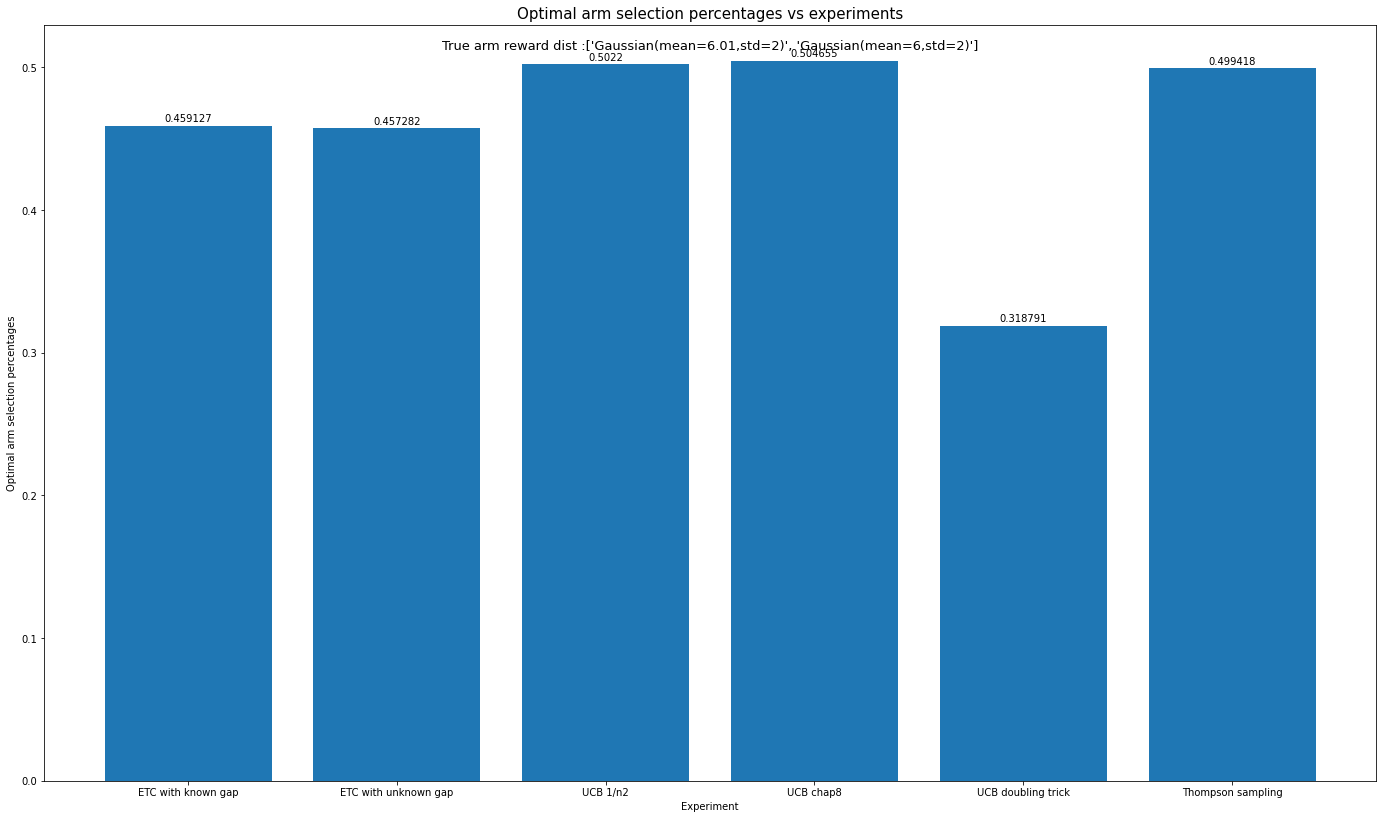

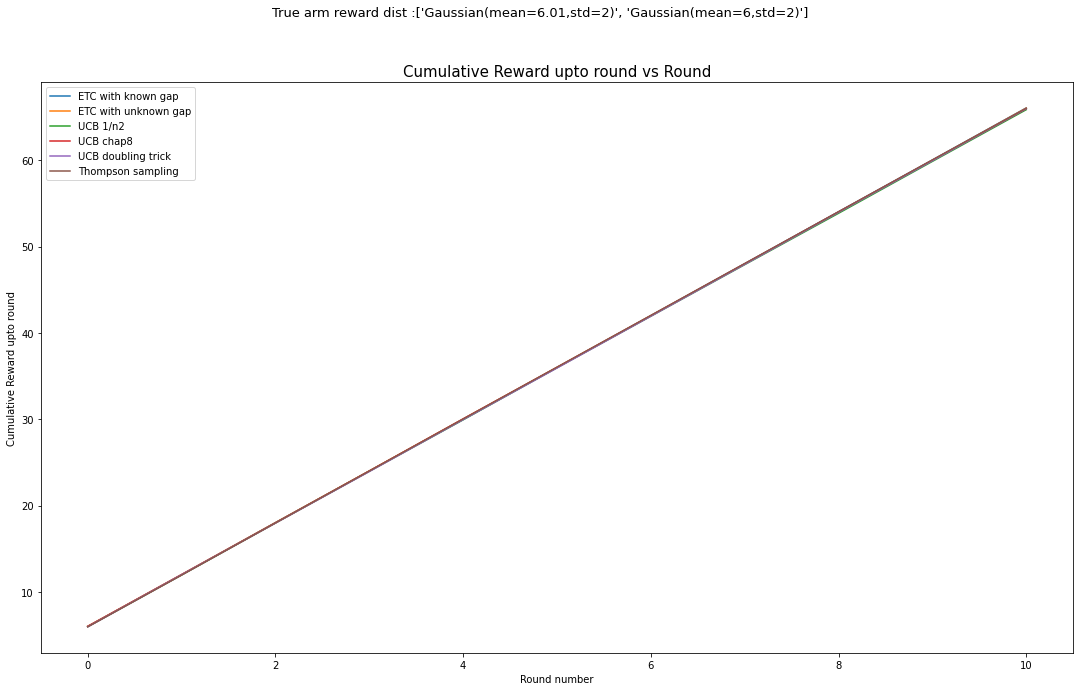

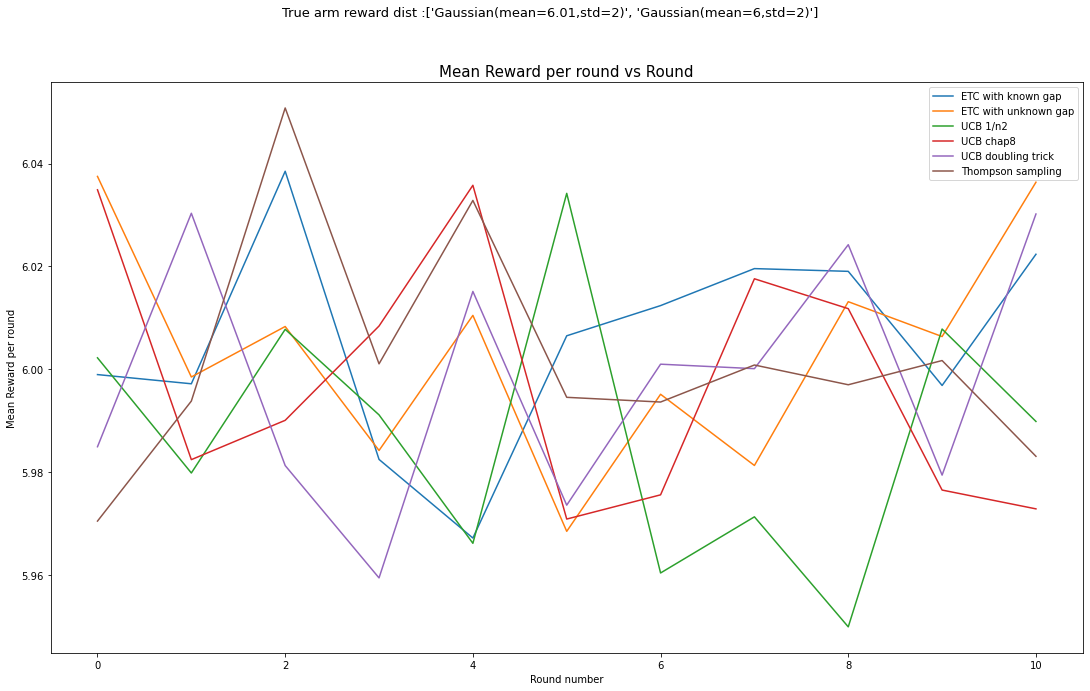

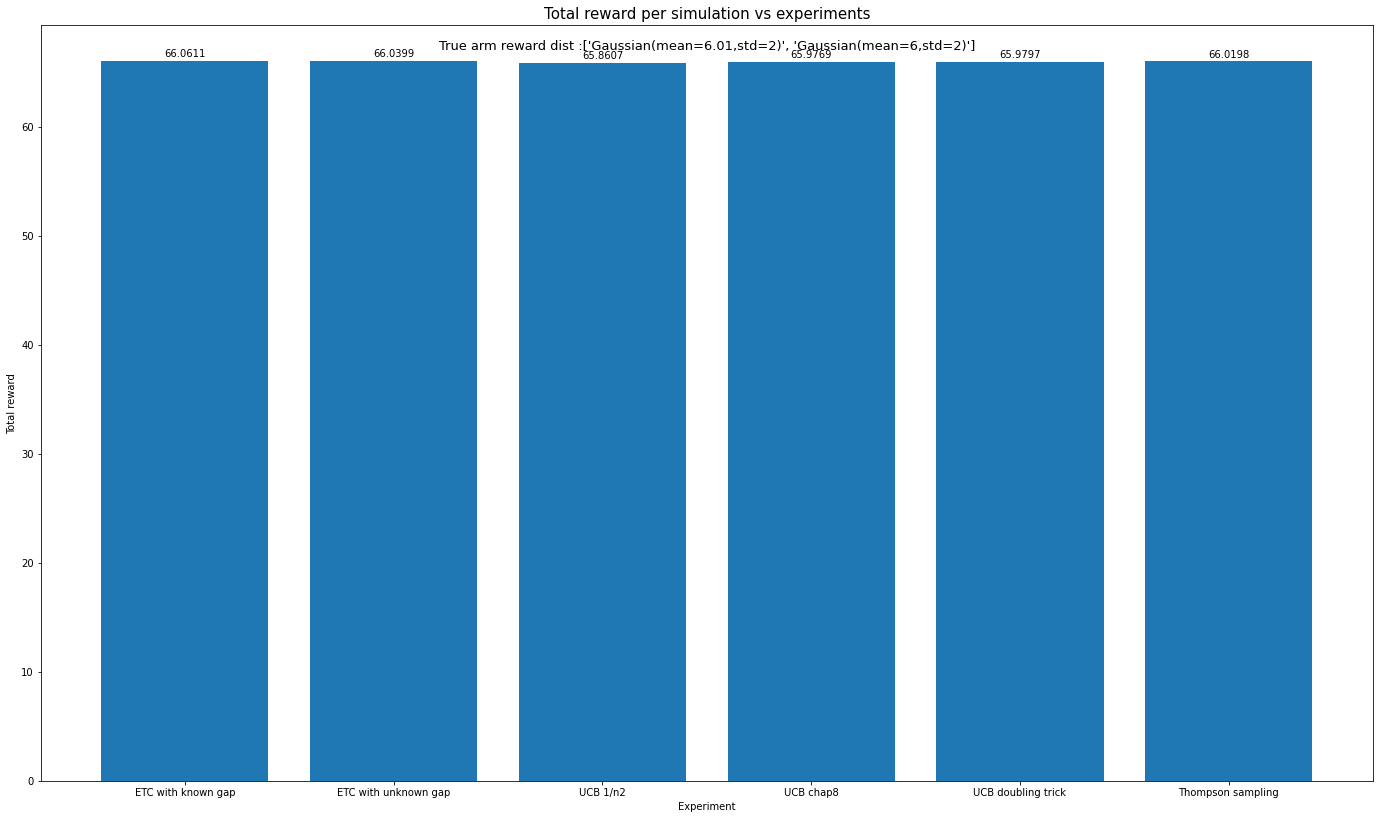

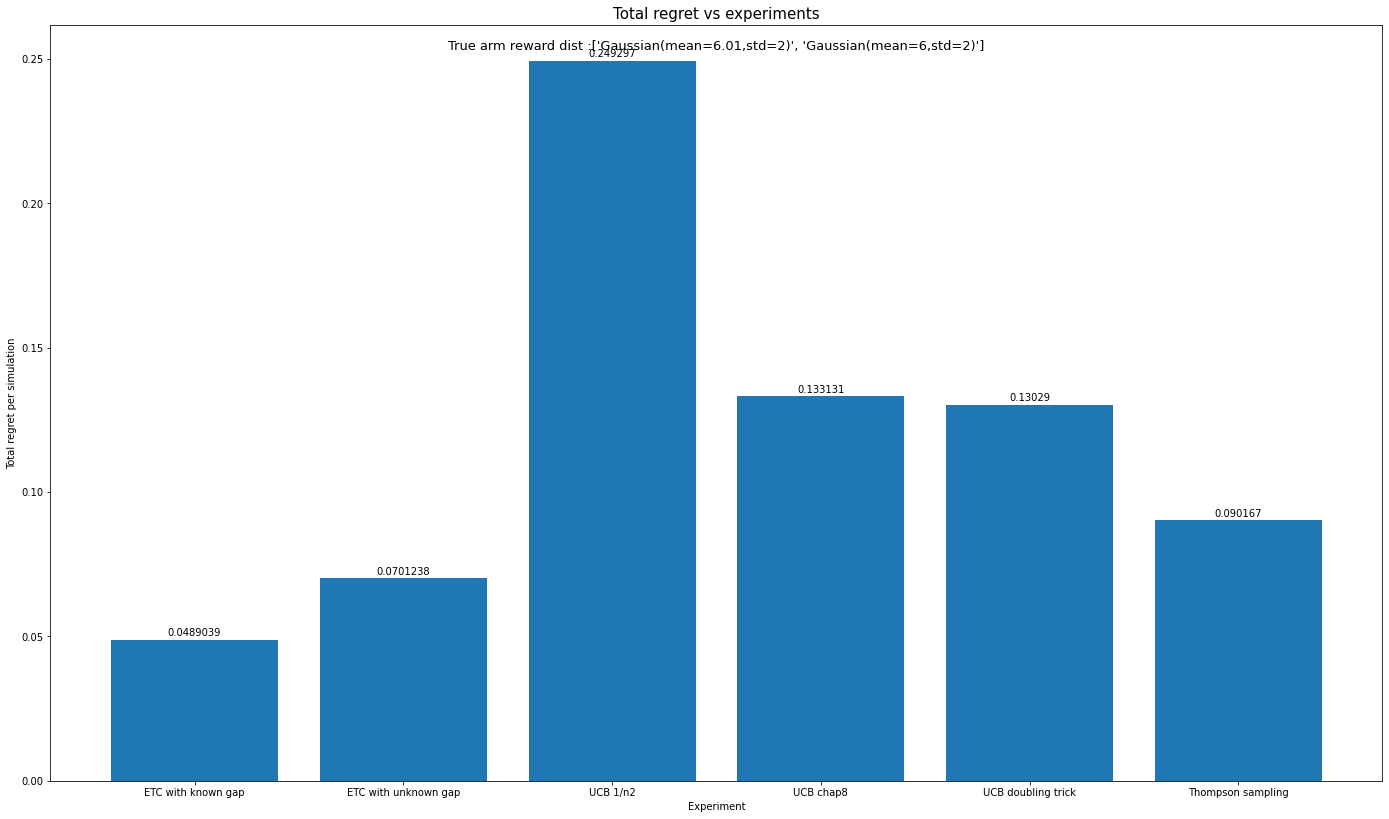

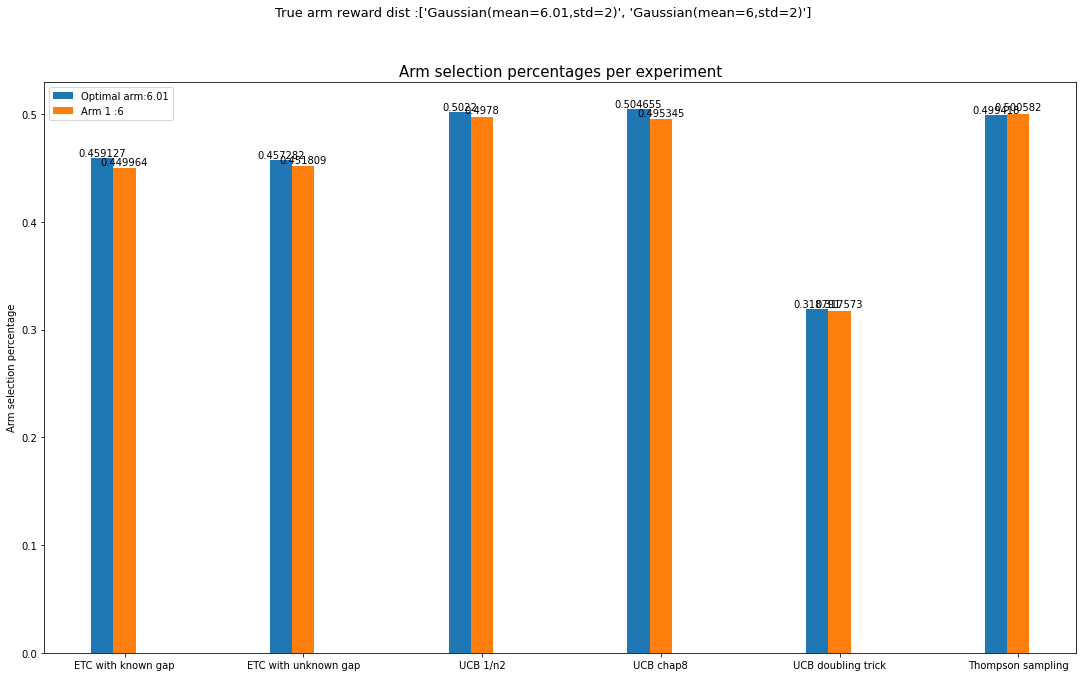

In [38]:
arm_true_mean_reward_list=[6.01,6]
prior_initial_parameter_dict={'known_precision':0.25,'mean':1,'precision':0.25}
experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=10000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution=get_gaussian_distribution_with_sd(2),prior_distribution_name='GAUSSIAN_KNOWN_VARIANCE',prior_initial_parameter_dict=prior_initial_parameter_dict)
plot_optimal_arm_selection_percentage(experimentObjs,exp_names)
plot_cumulative_reward_per_round(experimentObjs,exp_names)
plot_mean_reward_per_round(experimentObjs,exp_names)
plot_total_reward(experimentObjs,exp_names)
plot_total_regret(experimentObjs,exp_names)
plot_arm_percentages_overall(experimentObjs,exp_names)

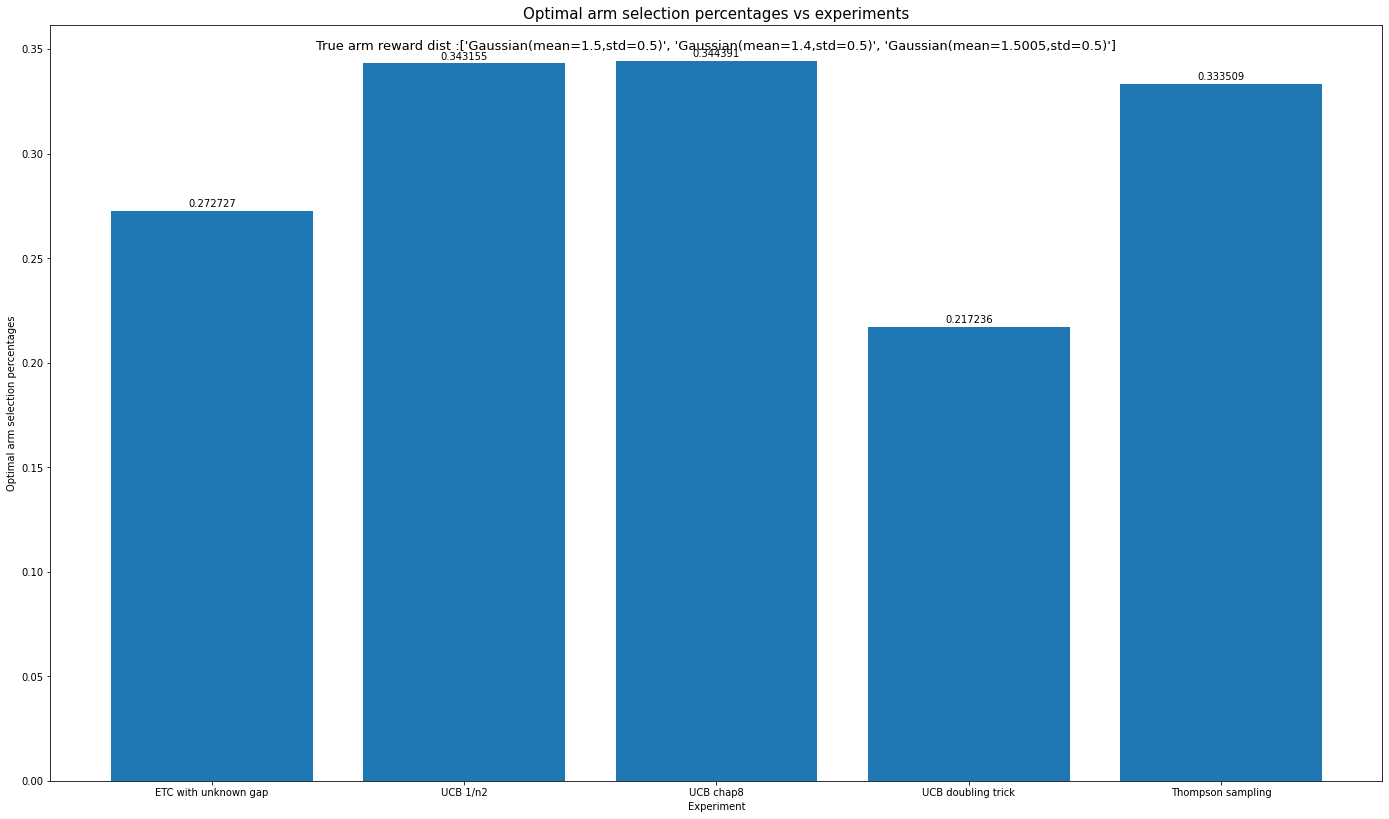

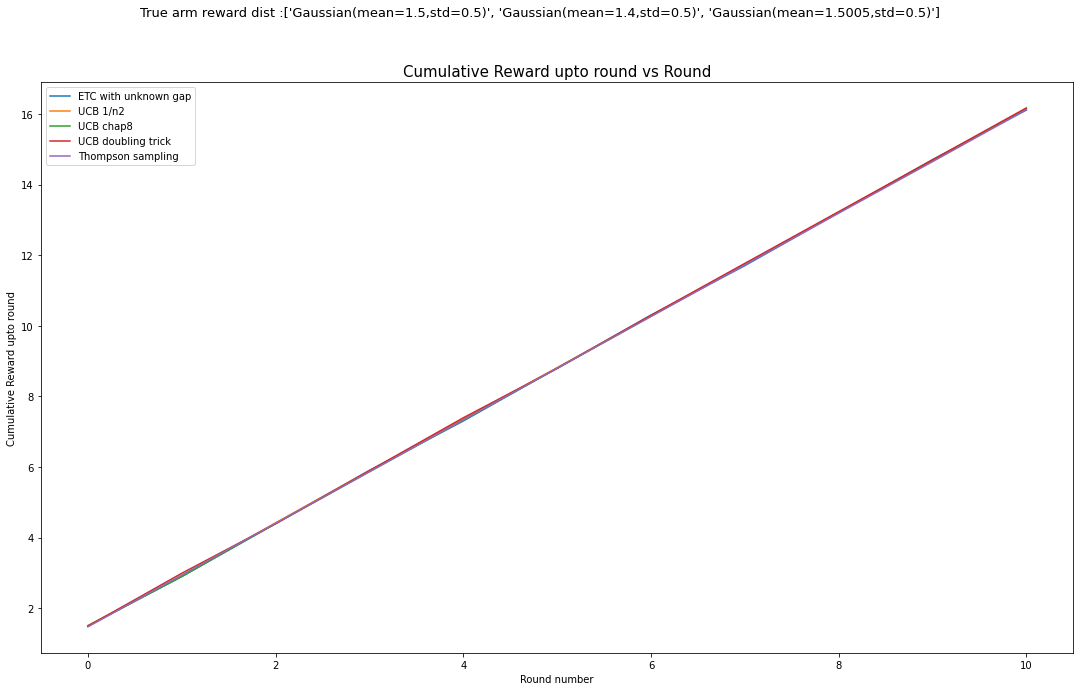

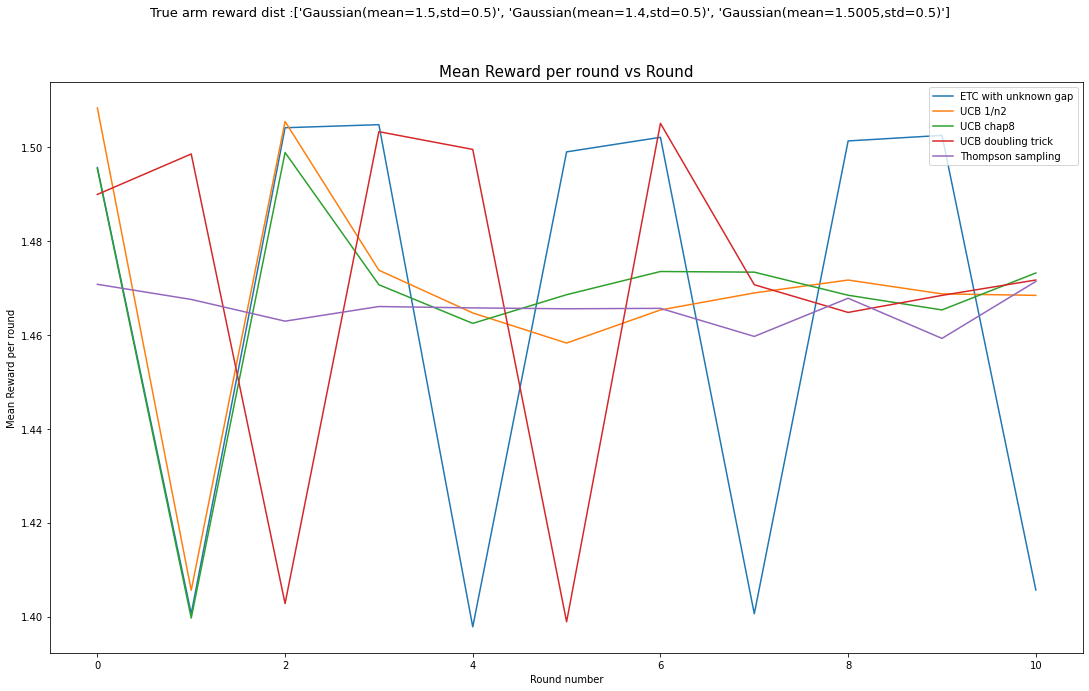

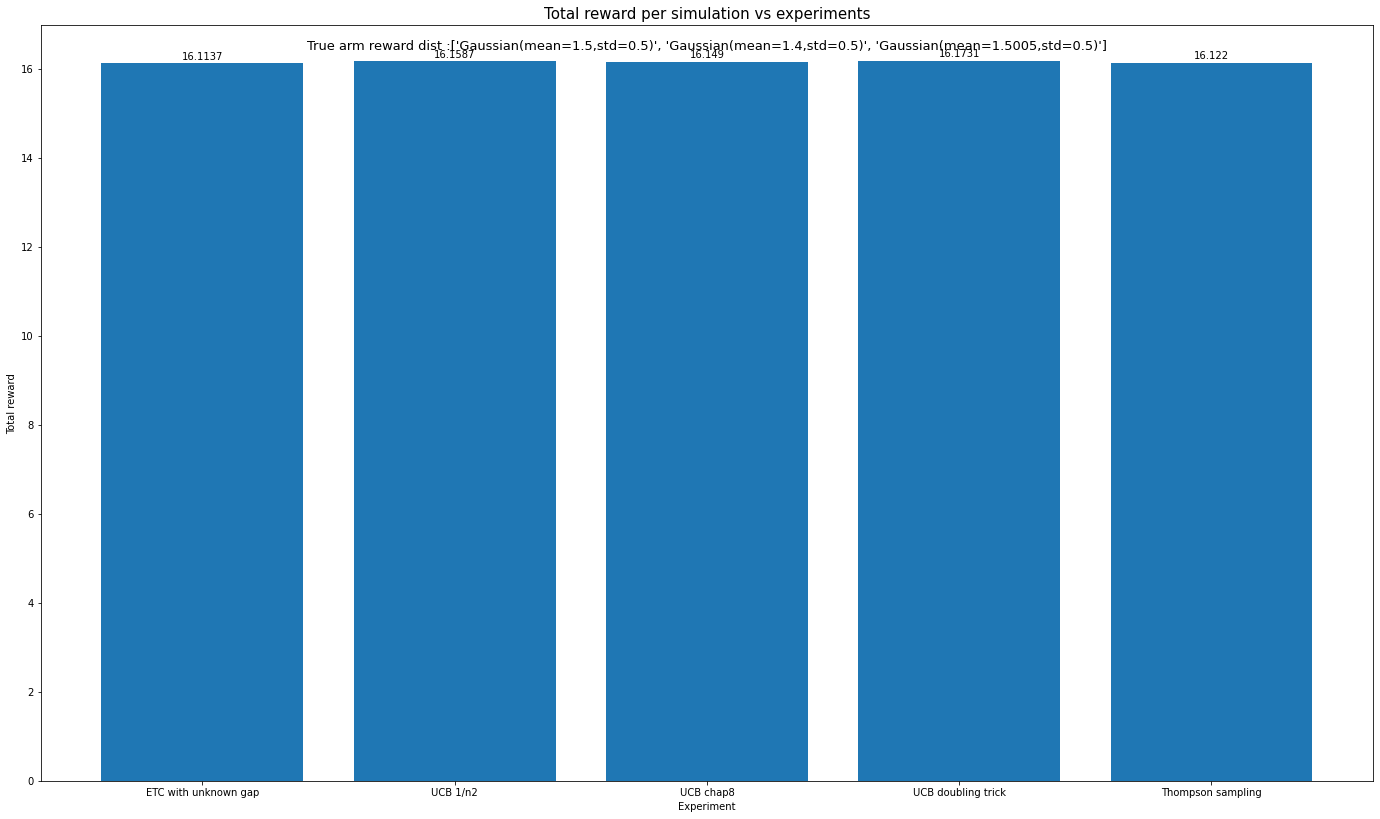

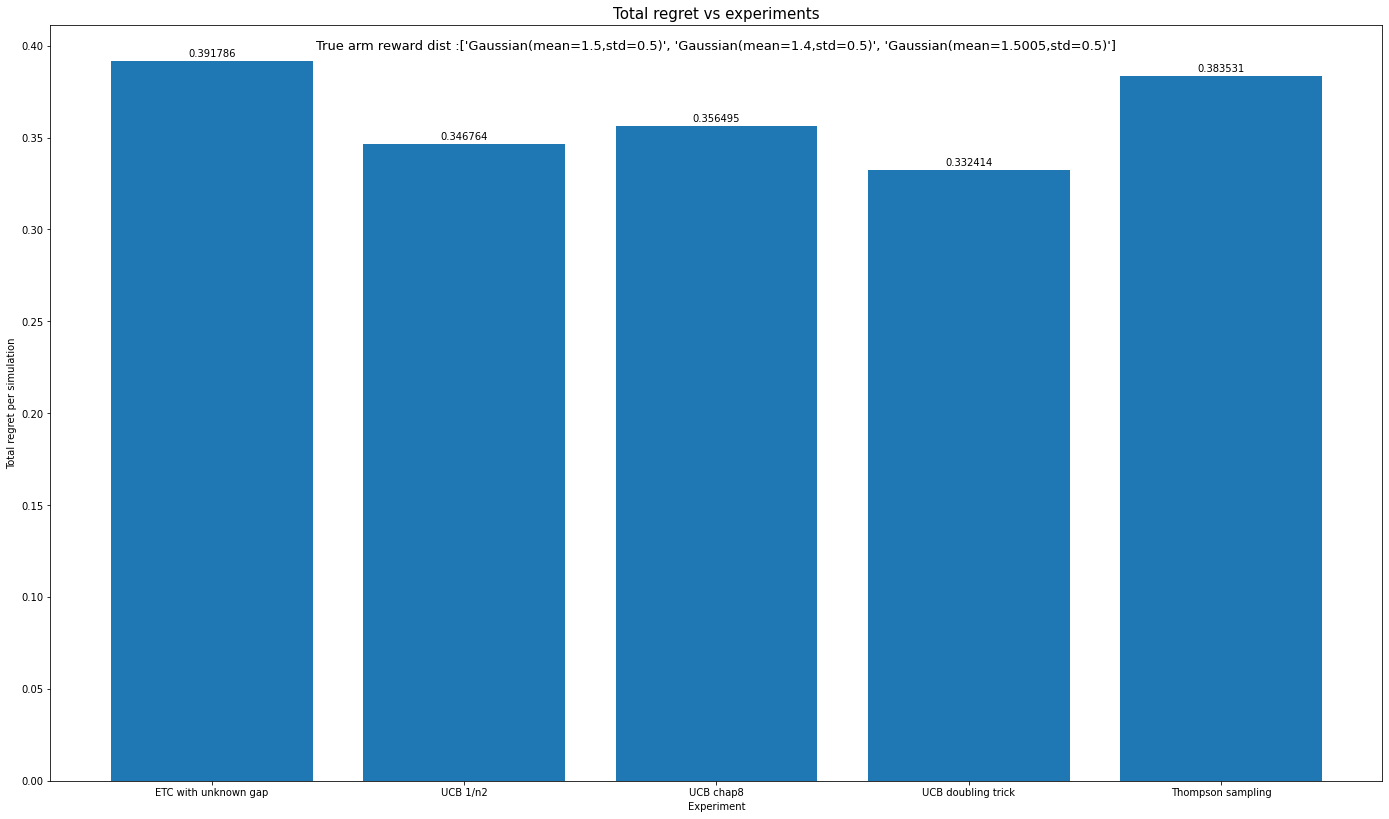

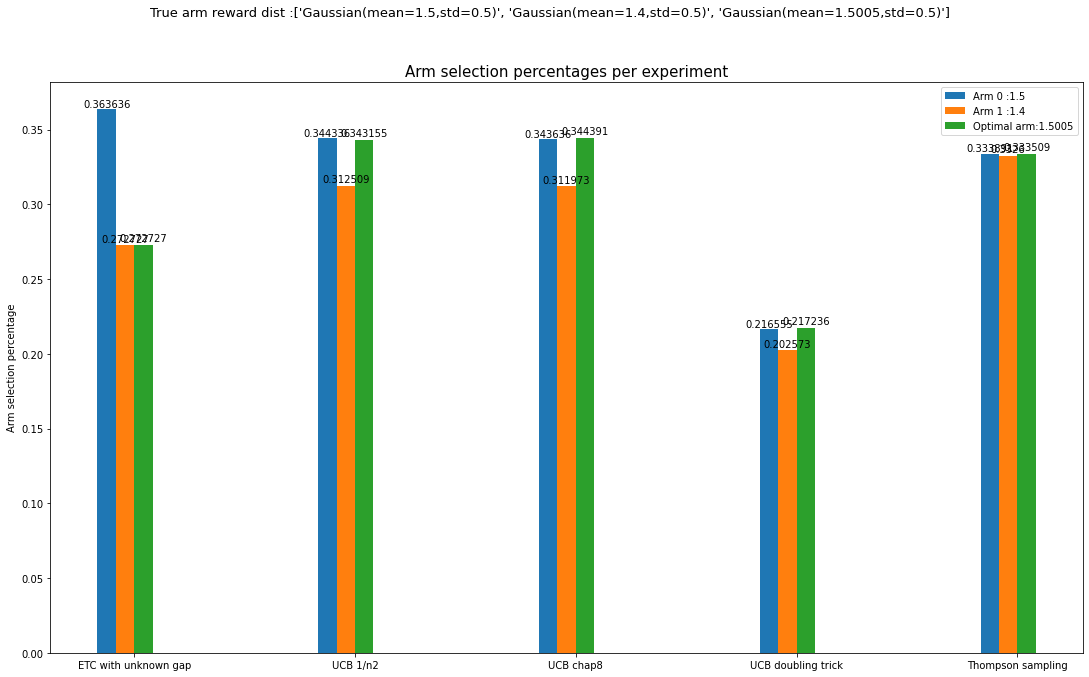

In [39]:
arm_true_mean_reward_list=[1.5,1.4,1.5005]
prior_initial_parameter_dict={'known_precision':4,'mean':1,'precision':4}
experimentObjs_g5,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=10000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution=get_gaussian_distribution_with_sd(0.5),prior_distribution_name='GAUSSIAN_KNOWN_VARIANCE',prior_initial_parameter_dict=prior_initial_parameter_dict)
plot_optimal_arm_selection_percentage(experimentObjs_g5,exp_names)
plot_cumulative_reward_per_round(experimentObjs_g5,exp_names)
plot_mean_reward_per_round(experimentObjs_g5,exp_names)
plot_total_reward(experimentObjs_g5,exp_names)
plot_total_regret(experimentObjs_g5,exp_names)
plot_arm_percentages_overall(experimentObjs_g5,exp_names)

#Graphs for uniform reward distribution

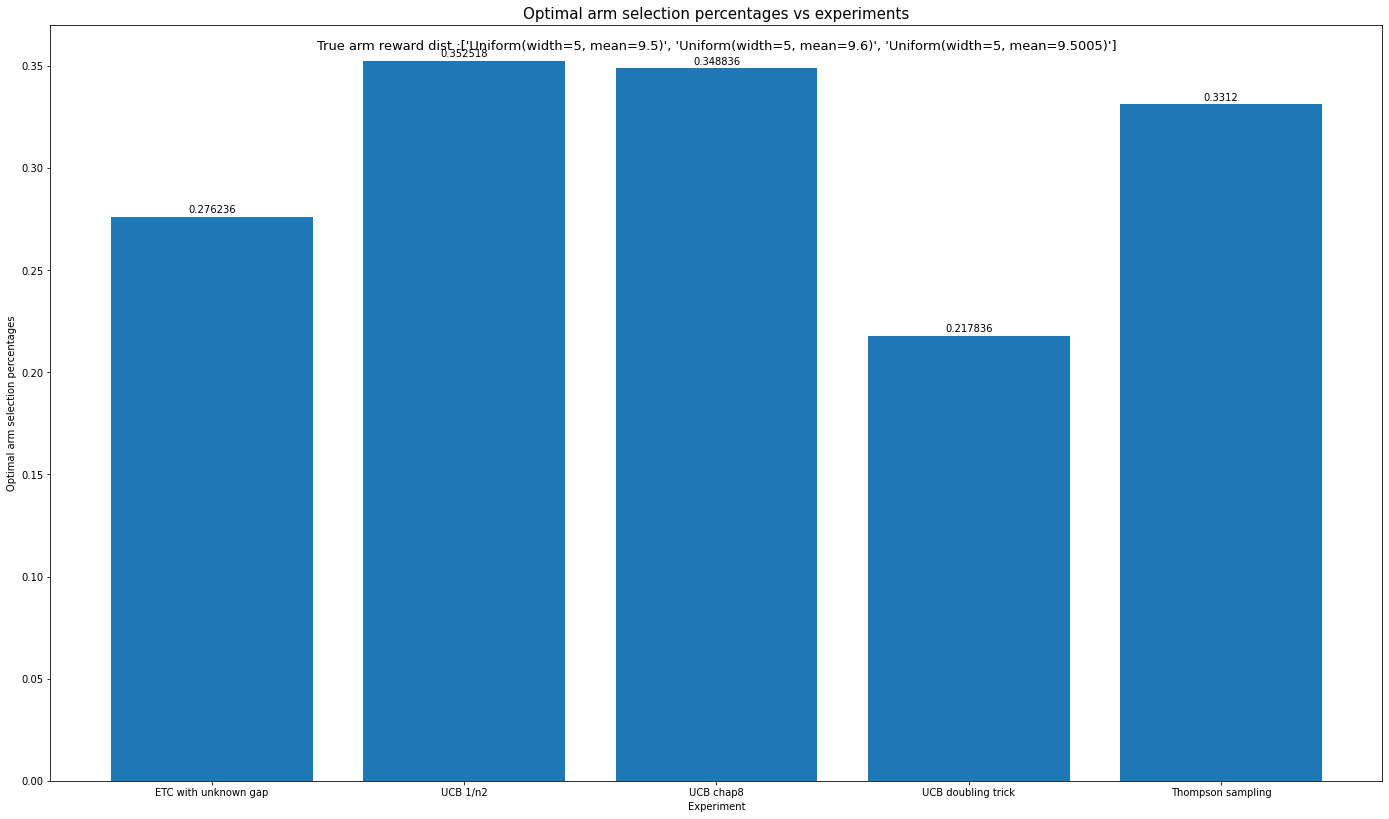

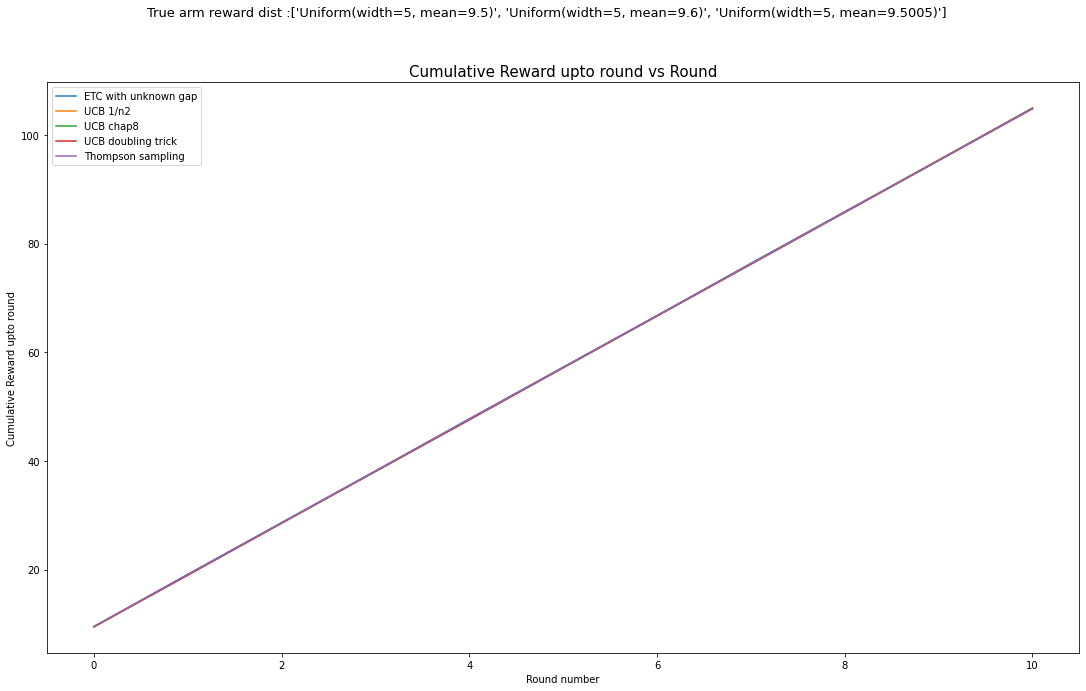

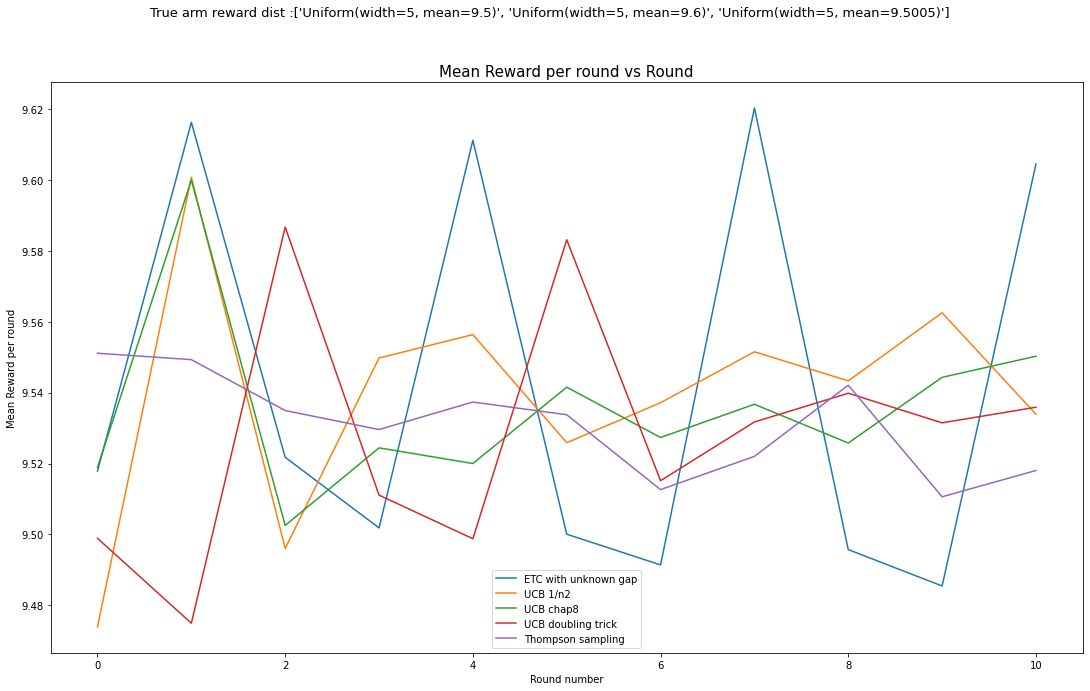

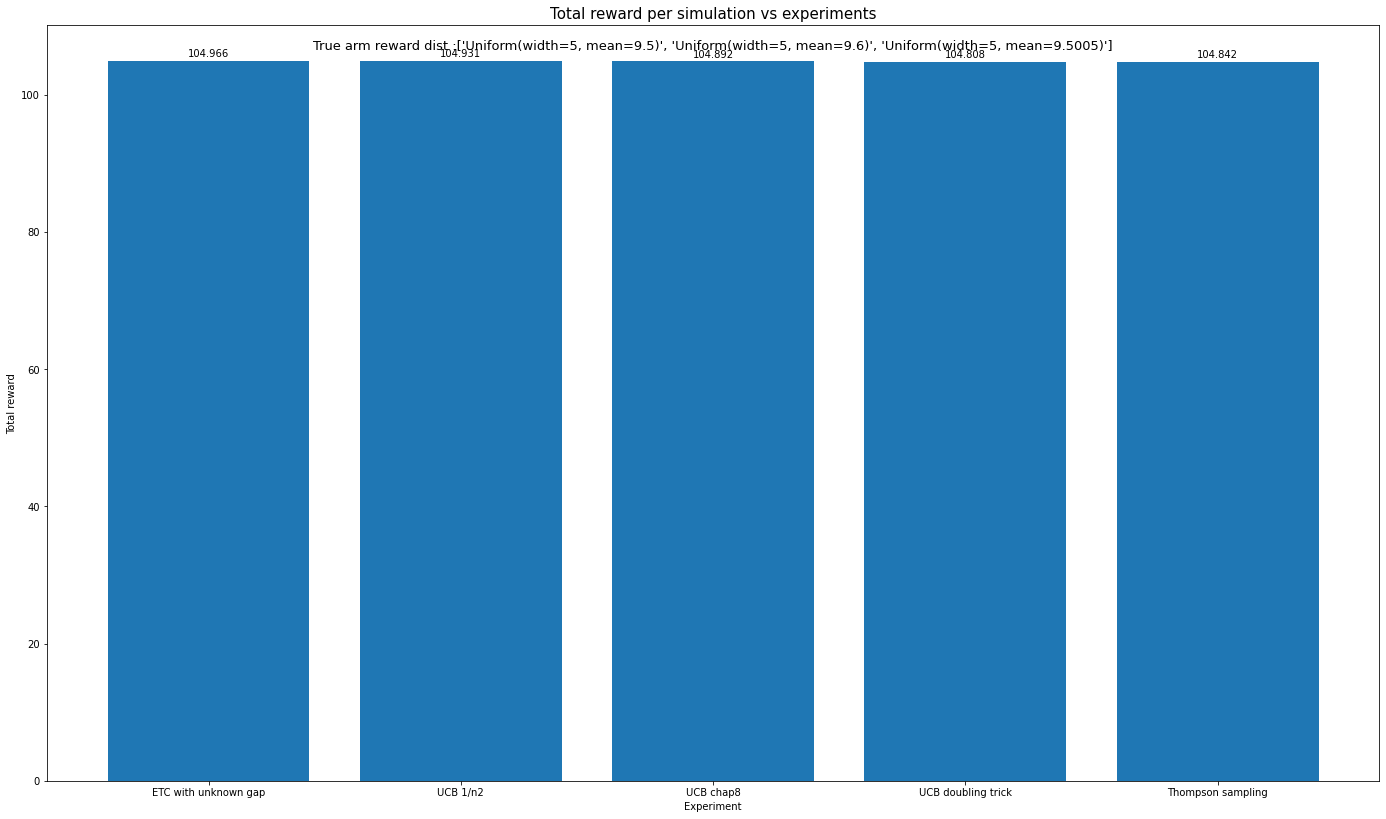

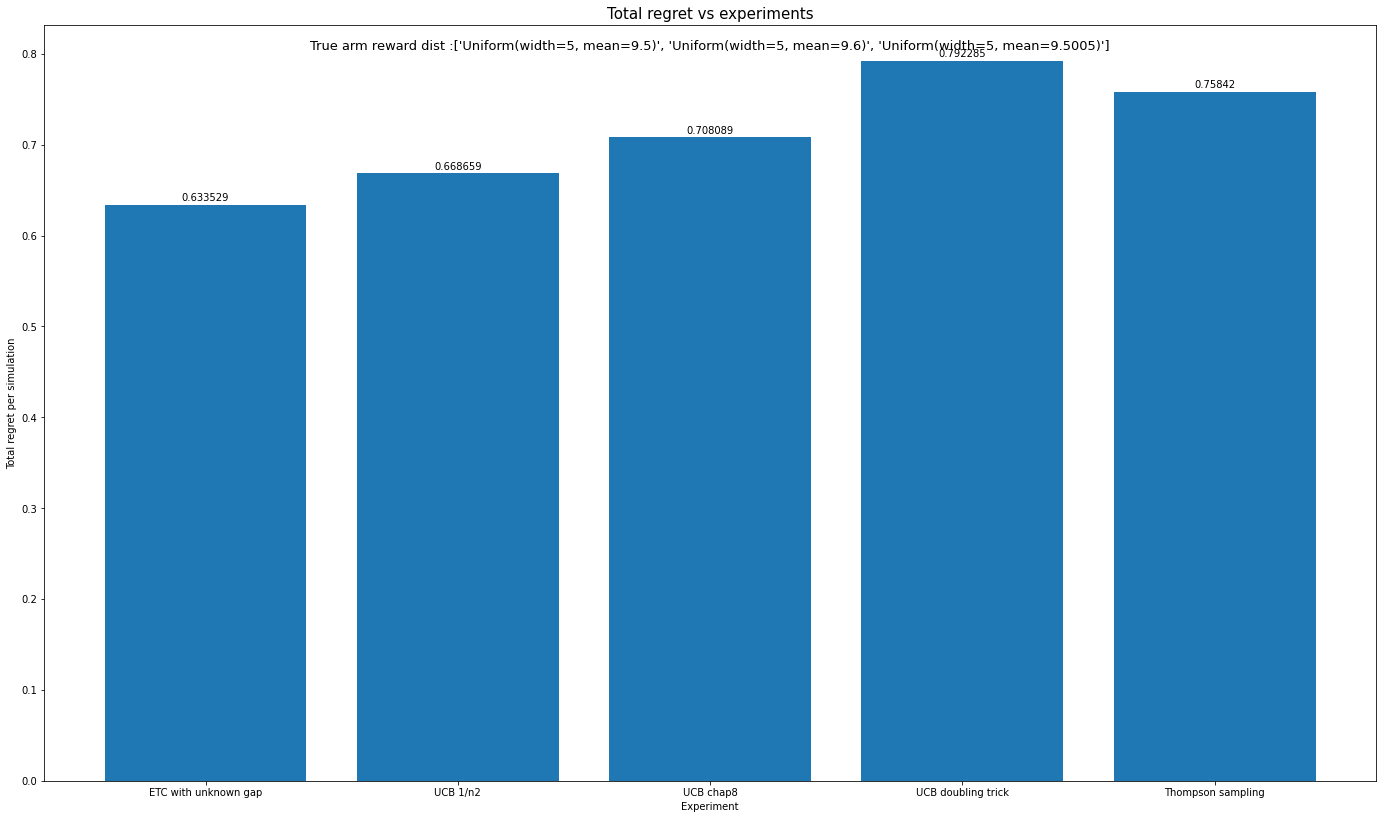

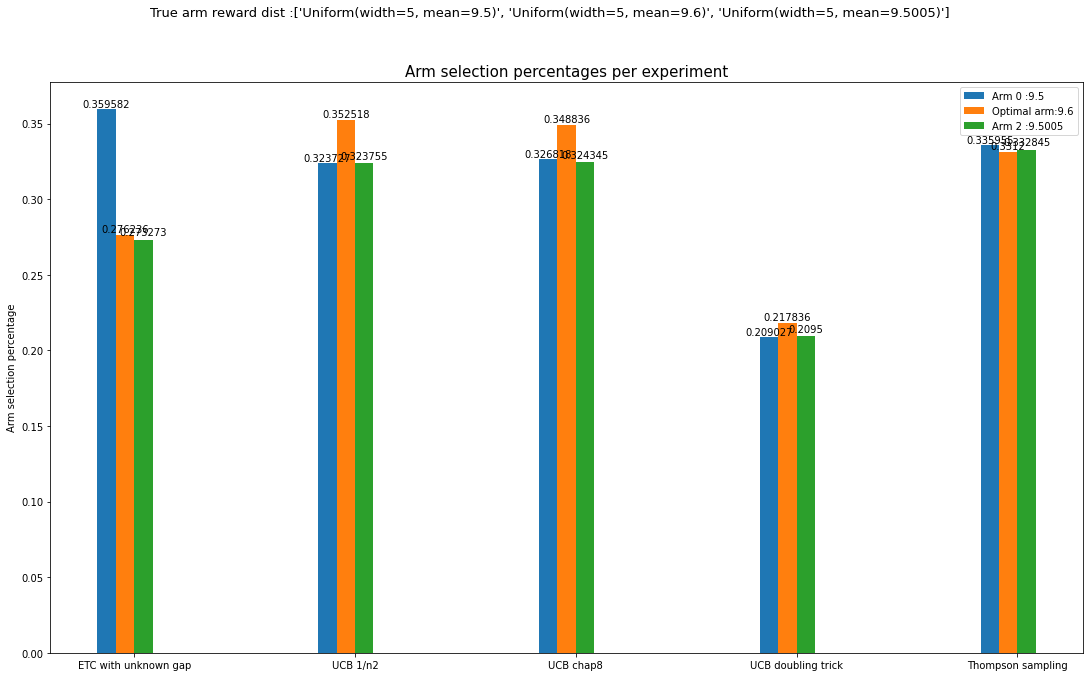

In [40]:
arm_true_mean_reward_list=[9.5,9.6,9.5005]
prior_initial_parameter_dict={'known_precision':0.04,'mean':1,'precision':0.04}
experimentObjs_uni_5,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=10000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution=get_uniform_distribution_with_sd(5),prior_distribution_name='GAUSSIAN_KNOWN_VARIANCE',prior_initial_parameter_dict=prior_initial_parameter_dict)
plot_optimal_arm_selection_percentage(experimentObjs_uni_5,exp_names)
plot_cumulative_reward_per_round(experimentObjs_uni_5,exp_names)
plot_mean_reward_per_round(experimentObjs_uni_5,exp_names)
plot_total_reward(experimentObjs_uni_5,exp_names)
plot_total_regret(experimentObjs_uni_5,exp_names)
plot_arm_percentages_overall(experimentObjs_uni_5,exp_names)

#Graphs for bernoulli reward distribution

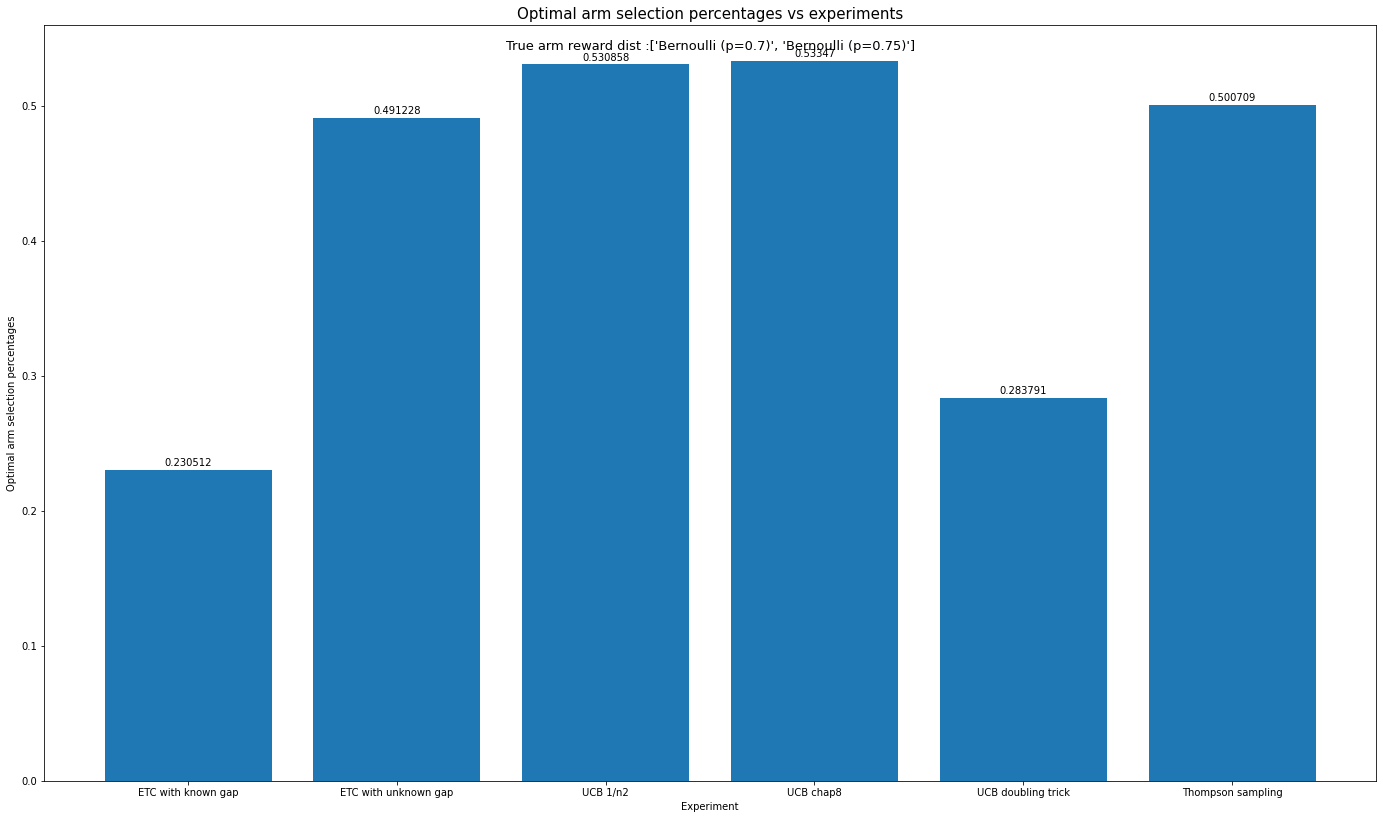

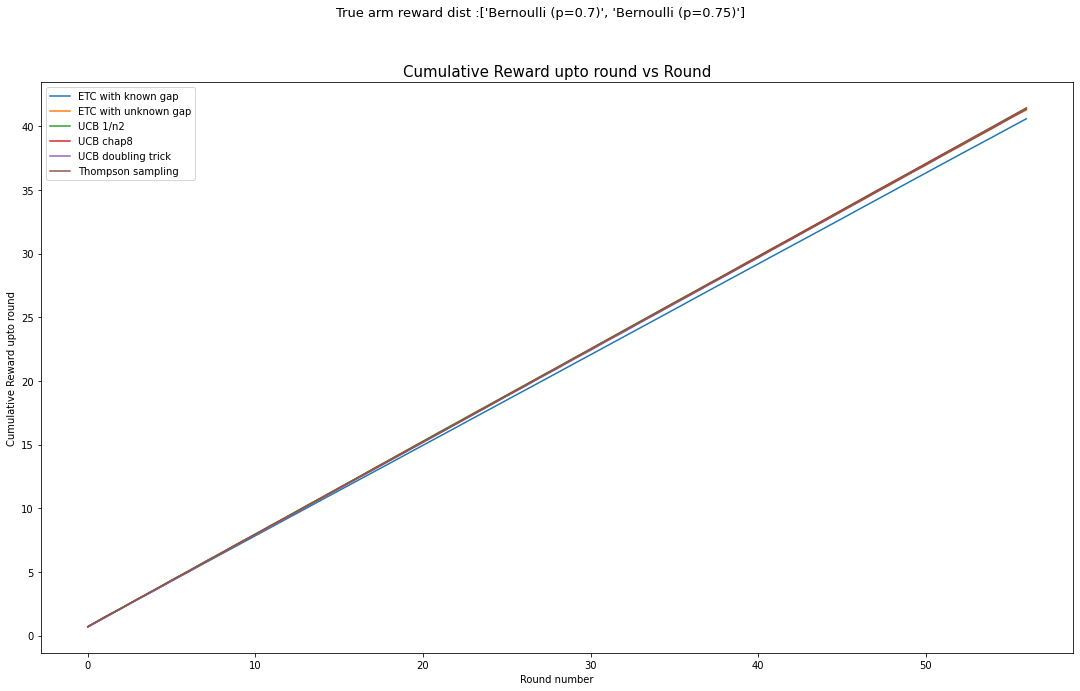

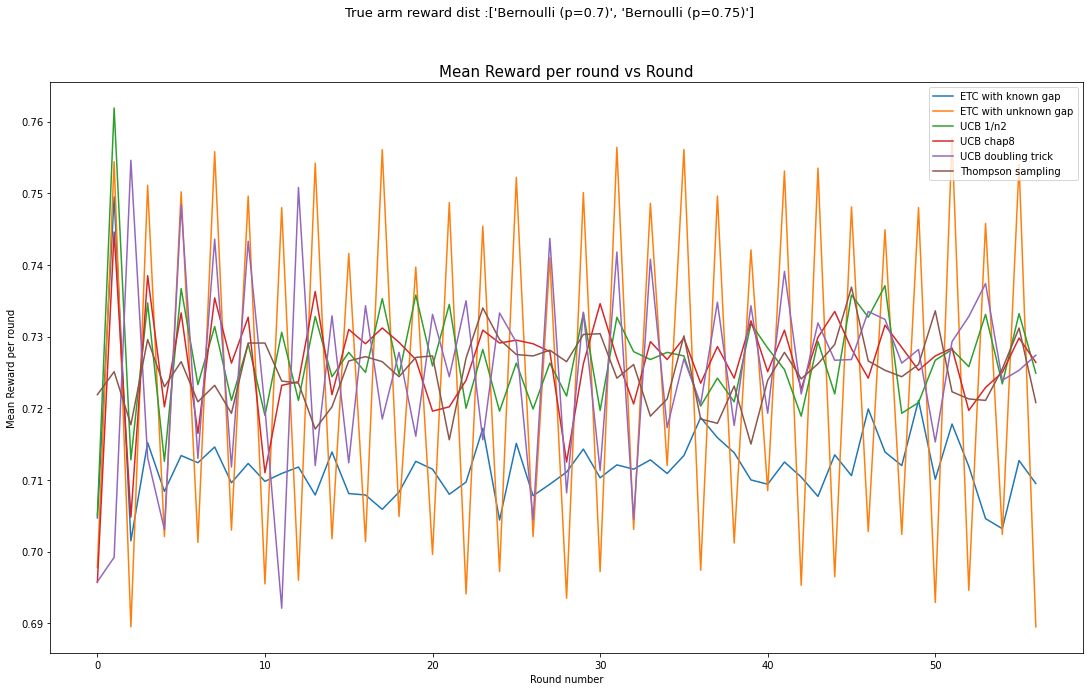

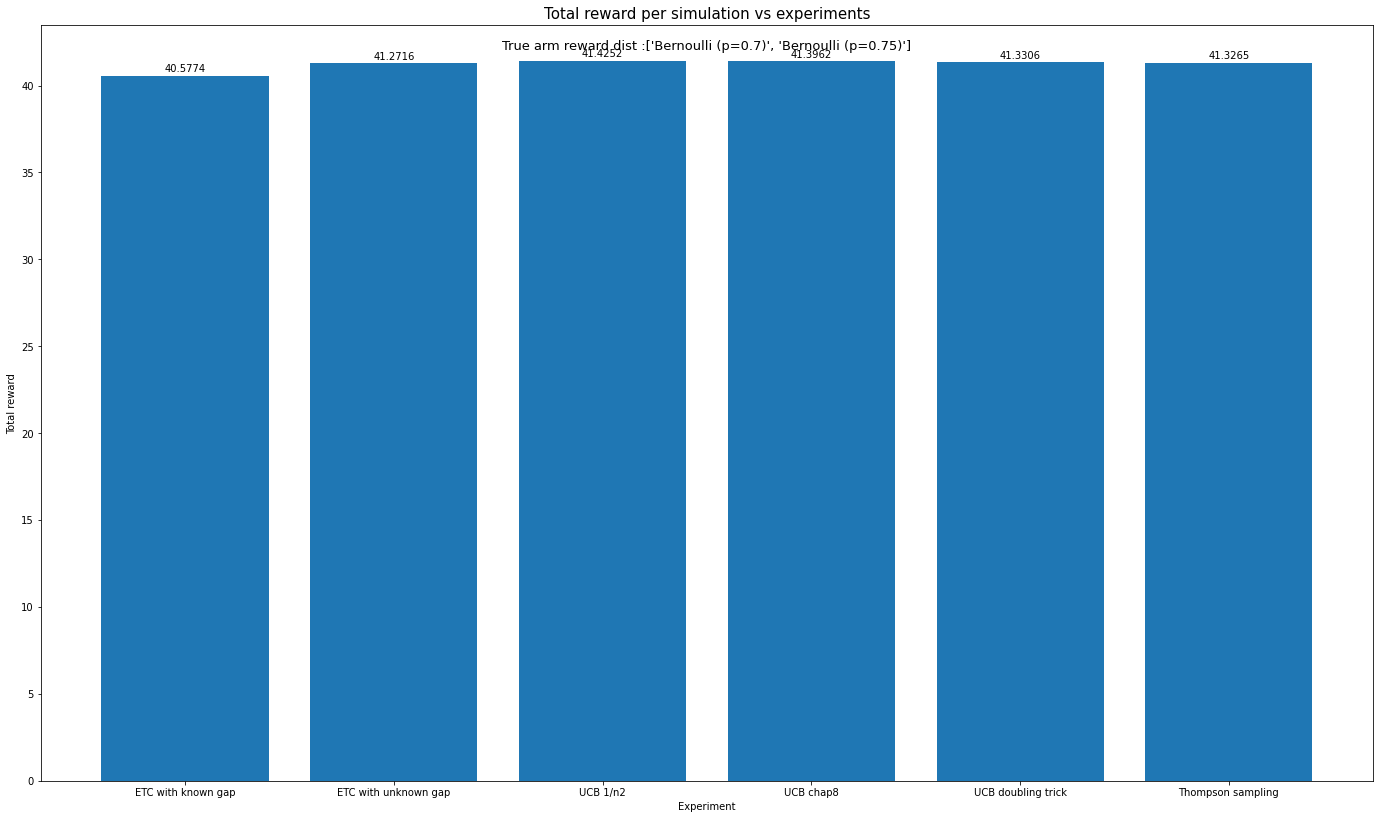

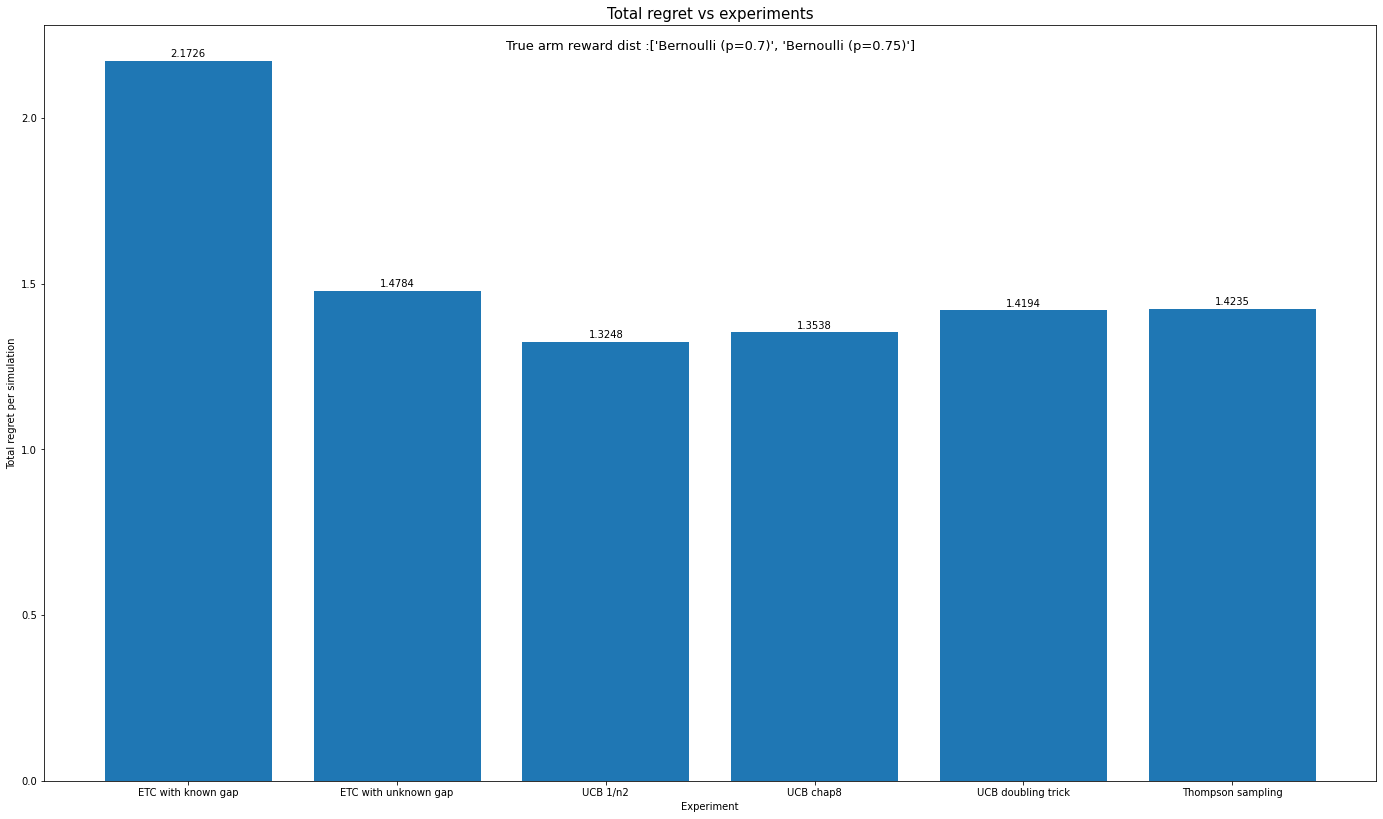

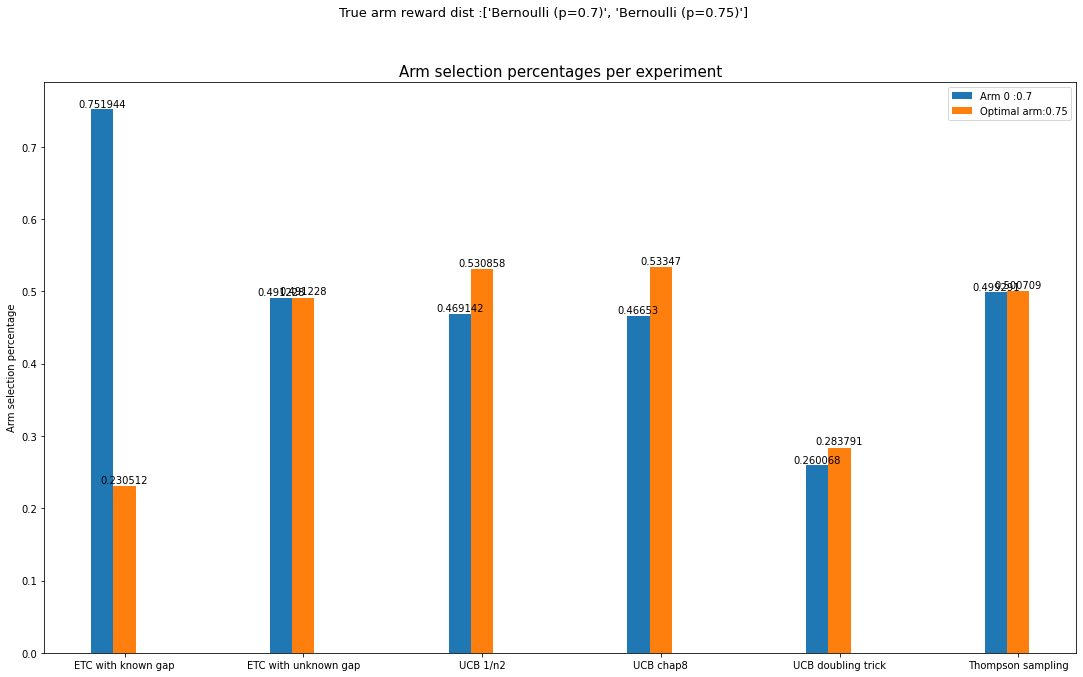

In [41]:
arm_true_mean_reward_list=[0.7,0.75]
prior_initial_parameter_dict={'alpha':1,'beta':1}
experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=10000,number_of_rounds_in_terms_of_unknown_order=5,reward_distribution=get_reward_from_bernoulli_distribution,prior_distribution_name='BETA',prior_initial_parameter_dict=prior_initial_parameter_dict)
plot_optimal_arm_selection_percentage(experimentObjs,exp_names)
plot_cumulative_reward_per_round(experimentObjs,exp_names)
plot_mean_reward_per_round(experimentObjs,exp_names)
plot_total_reward(experimentObjs,exp_names)
plot_total_regret(experimentObjs,exp_names)
plot_arm_percentages_overall(experimentObjs,exp_names)

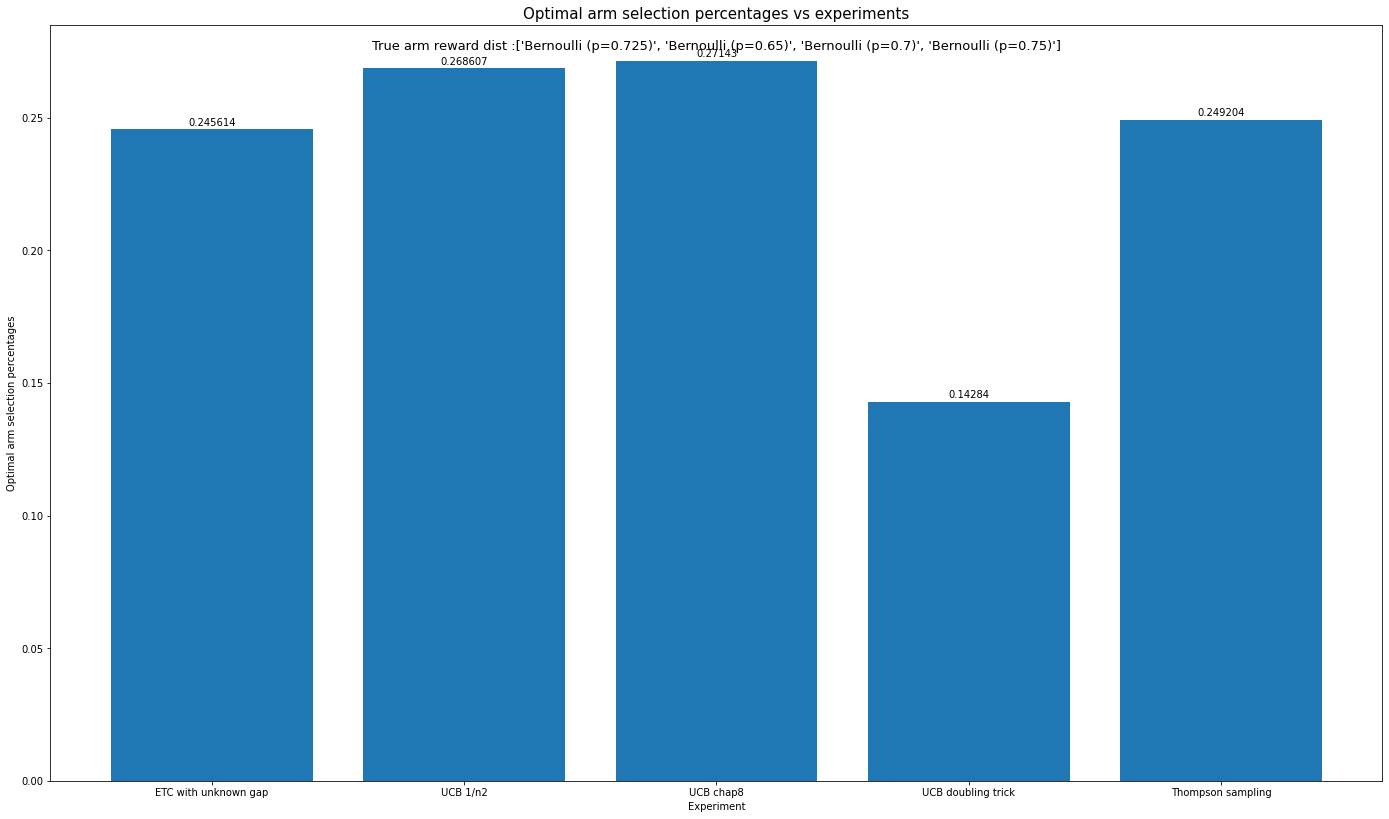

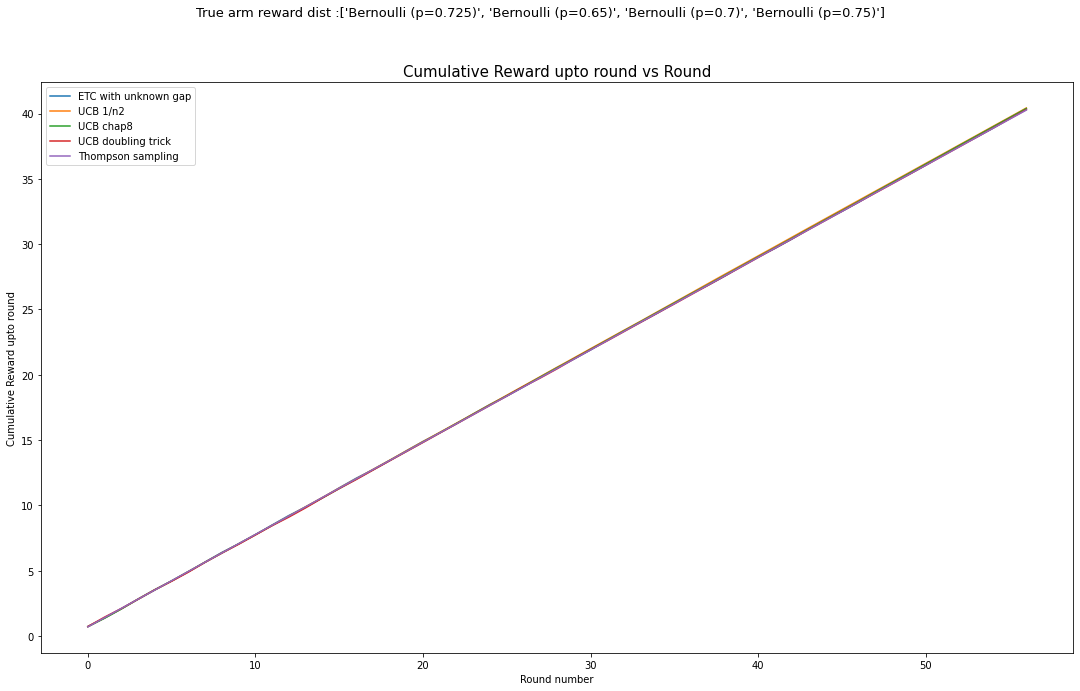

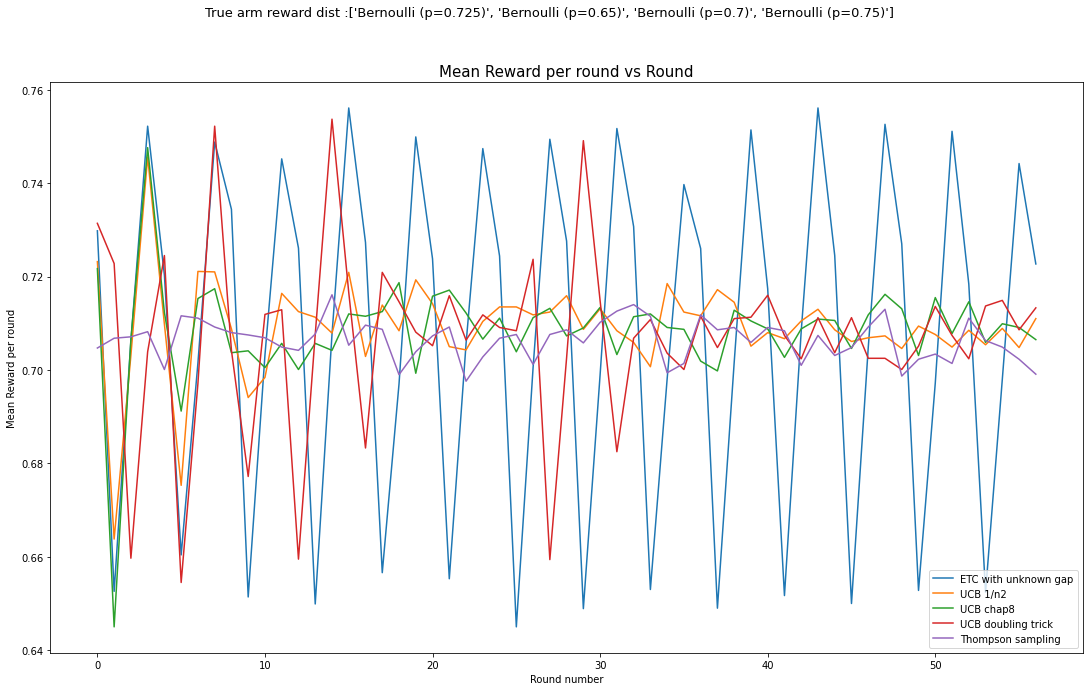

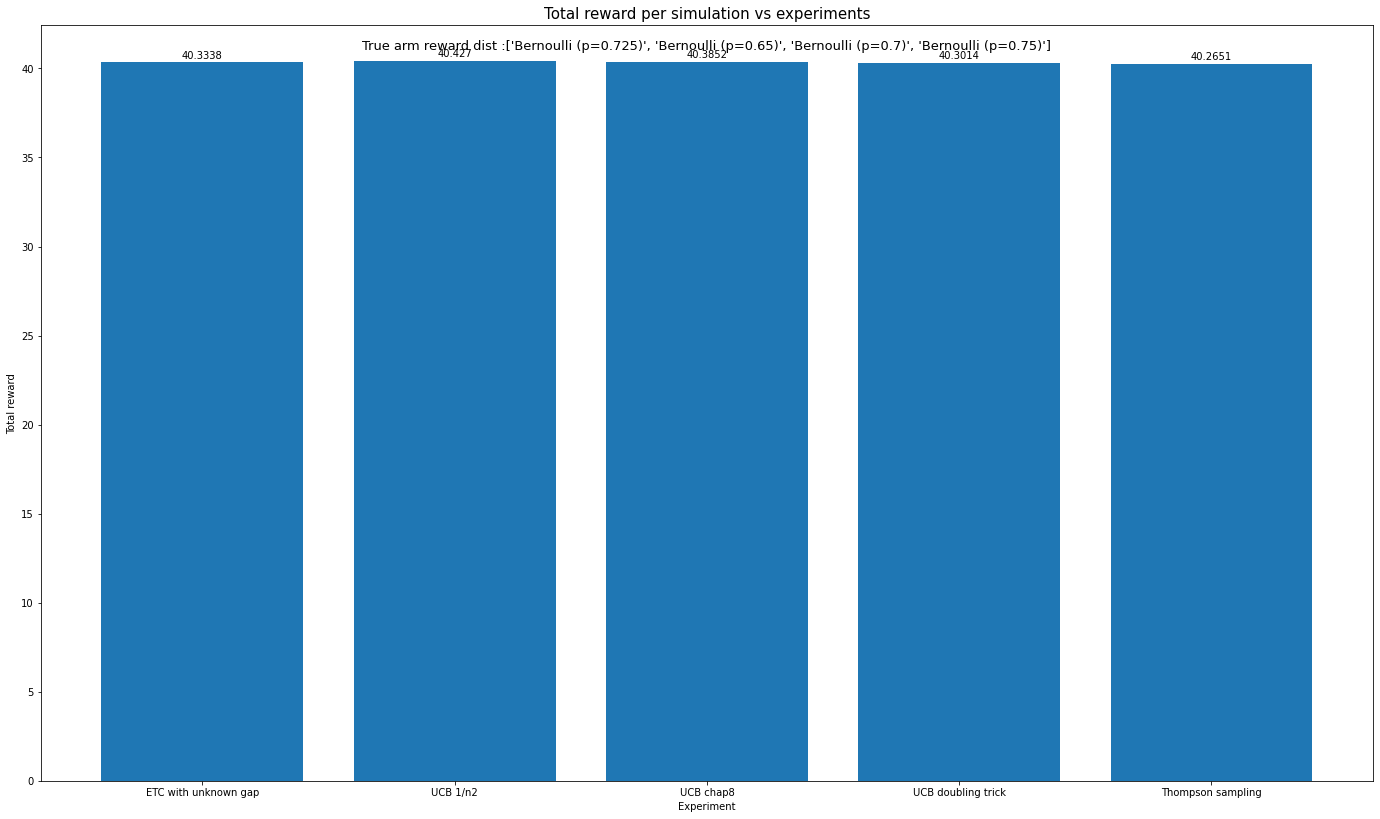

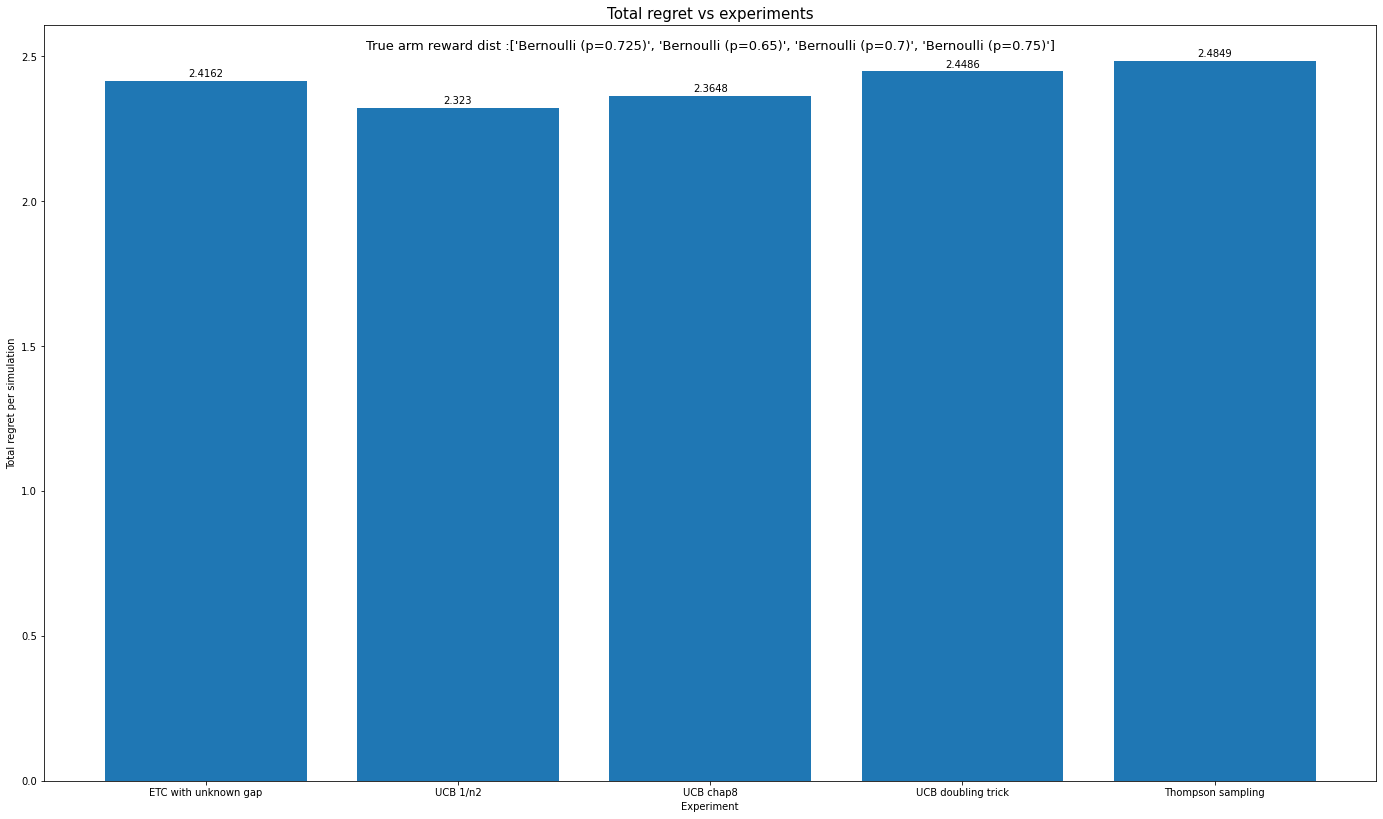

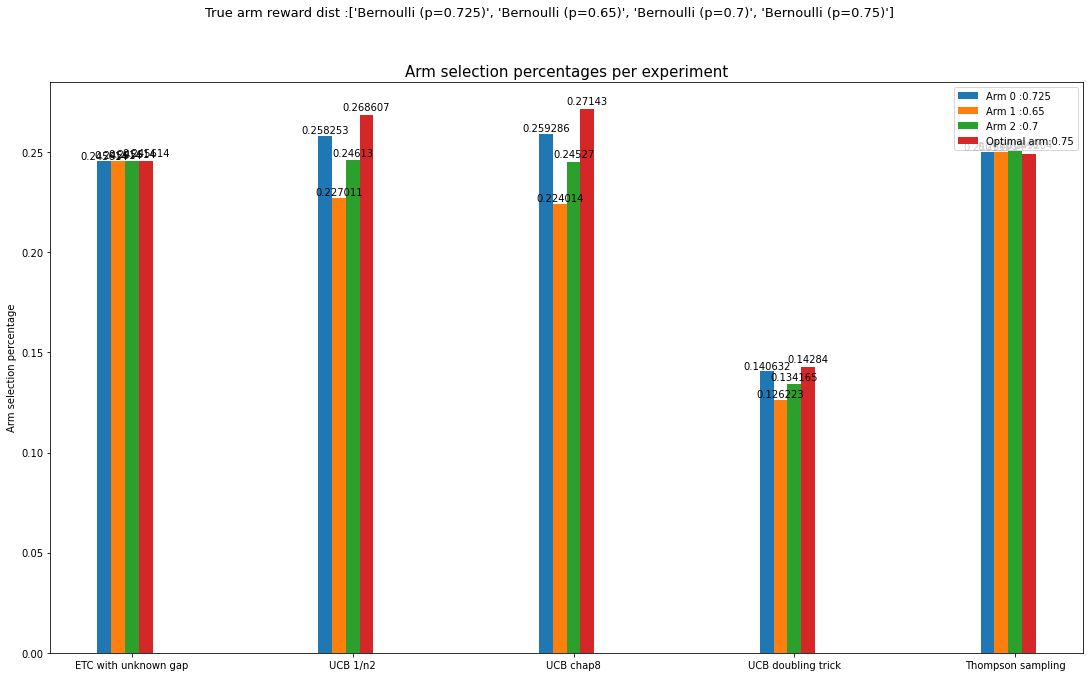

In [42]:
arm_true_mean_reward_list=[0.725,0.65,0.7,0.75]
prior_initial_parameter_dict={'alpha':1,'beta':1}
experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=10000,number_of_rounds_in_terms_of_unknown_order=5,reward_distribution=get_reward_from_bernoulli_distribution,prior_distribution_name='BETA',prior_initial_parameter_dict=prior_initial_parameter_dict)
plot_optimal_arm_selection_percentage(experimentObjs,exp_names)
plot_cumulative_reward_per_round(experimentObjs,exp_names)
plot_mean_reward_per_round(experimentObjs,exp_names)
plot_total_reward(experimentObjs,exp_names)
plot_total_regret(experimentObjs,exp_names)
plot_arm_percentages_overall(experimentObjs,exp_names)

##Animation related code begins

In [43]:
#Either vary distribution variance to see animation across variations. Or vary the number of rounds or vary the difference between each arm
def get_simulation_results_across_configs(arm_true_reward_difference,number_of_arms,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution_code,reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=None,varying_arm_difference_list=None):
  experimentObjsList = []
  if(not(varying_distribution_param_list is None)):
    for each_distribution_param in varying_distribution_param_list:
      arm_true_mean_reward_list=[]
      if(reward_distribution_code=='GAUSSIAN'):
        for arm_index in range(number_of_arms):
          #In gaussian dist, 97% of mass is in 3*sd. Hence arm_reward will be more than 3*sd
          arm_true_mean_reward_list.append(3 * each_distribution_param + (arm_index) * arm_true_reward_difference)
        known_prec = 1/math.pow(each_distribution_param,2)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution=get_gaussian_distribution_with_sd(each_distribution_param),prior_distribution_name="GAUSSIAN_KNOWN_VARIANCE",prior_initial_parameter_dict={'known_precision':known_prec,'mean':0,'precision':known_prec})
        experimentObjsList.append(experimentObjs)
      elif(reward_distribution_code=='UNIFORM'):
        for arm_index in range(number_of_arms):
          arm_true_mean_reward_list.append((each_distribution_param/2) + (arm_index) * arm_true_reward_difference)
        known_prec = 1/math.pow(each_distribution_param,2)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution=get_uniform_distribution_with_sd(each_distribution_param),prior_distribution_name="GAUSSIAN_KNOWN_VARIANCE",prior_initial_parameter_dict={'known_precision':known_prec,'mean':0,'precision':known_prec})
        experimentObjsList.append(experimentObjs)
      
  elif(not(varying_number_of_rounds_param_list is None)):
    for each_number_of_rounds in varying_number_of_rounds_param_list:
      arm_true_mean_reward_list=[]
      if(reward_distribution_code=='GAUSSIAN'):
        for arm_index in range(number_of_arms):
          #In gaussian dist, 97% of mass is in 3*sd. Hence arm_reward will be more than 3*sd
          arm_true_mean_reward_list.append(3 * reward_distribution_param + (arm_index) * arm_true_reward_difference)
        known_prec = 1/math.pow(reward_distribution_param,2)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=each_number_of_rounds,reward_distribution=get_gaussian_distribution_with_sd(reward_distribution_param),prior_distribution_name="GAUSSIAN_KNOWN_VARIANCE",prior_initial_parameter_dict={'known_precision':known_prec,'mean':0,'precision':known_prec})
        experimentObjsList.append(experimentObjs)
      elif(reward_distribution_code=='UNIFORM'):
        for arm_index in range(number_of_arms):
          arm_true_mean_reward_list.append((reward_distribution_param/2) + (arm_index) * arm_true_reward_difference)
        known_prec = 1/math.pow(reward_distribution_param,2)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=each_number_of_rounds,reward_distribution=get_uniform_distribution_with_sd(reward_distribution_param),prior_distribution_name="GAUSSIAN_KNOWN_VARIANCE",prior_initial_parameter_dict={'known_precision':known_prec,'mean':0,'precision':known_prec})
        experimentObjsList.append(experimentObjs)
      elif(reward_distribution_code=='BERNOULLI'):
        for arm_index in range(number_of_arms):
          arm_true_mean_reward_list.append(0.4 + (arm_index) * arm_true_reward_difference)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=each_number_of_rounds,reward_distribution=get_reward_from_bernoulli_distribution,prior_distribution_name="BETA",prior_initial_parameter_dict={'alpha':1,'beta':1})
        experimentObjsList.append(experimentObjs)
      
  elif(not(varying_arm_difference_list is None)):
    for each_arm_difference in varying_arm_difference_list:
      arm_true_mean_reward_list=[]
      if(reward_distribution_code=='GAUSSIAN'):
        for arm_index in range(number_of_arms):
          #In gaussian dist, 97% of mass is in 3*sd. Hence arm_reward will be more than 3*sd
          arm_true_mean_reward_list.append(3 * reward_distribution_param + (arm_index) * each_arm_difference)
        known_prec = 1/math.pow(reward_distribution_param,2)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution=get_gaussian_distribution_with_sd(reward_distribution_param),prior_distribution_name="GAUSSIAN_KNOWN_VARIANCE",prior_initial_parameter_dict={'known_precision':known_prec,'mean':0,'precision':known_prec})
        experimentObjsList.append(experimentObjs)
      elif(reward_distribution_code=='UNIFORM'):
        for arm_index in range(number_of_arms):
          arm_true_mean_reward_list.append((reward_distribution_param/2) + (arm_index) * each_arm_difference)
        known_prec = 1/math.pow(reward_distribution_param,2)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution=get_uniform_distribution_with_sd(reward_distribution_param),prior_distribution_name="GAUSSIAN_KNOWN_VARIANCE",prior_initial_parameter_dict={'known_precision':known_prec,'mean':0,'precision':known_prec})
        experimentObjsList.append(experimentObjs)
      elif(reward_distribution_code=='BERNOULLI'):
        for arm_index in range(number_of_arms):
          arm_true_mean_reward_list.append(0.4 + (arm_index) * each_arm_difference)
        experimentObjs,exp_names = get_simulation_results(arm_true_mean_reward_list,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution=get_reward_from_bernoulli_distribution,prior_distribution_name="BETA",prior_initial_parameter_dict={'alpha':1,'beta':1})
        experimentObjsList.append(experimentObjs)
      
  return experimentObjsList,exp_names


In [44]:
def animate_optimal_arm_percentages(experimentObjsList,exp_names,arm_difference_list=None,append_title=''):
  fig = plt.figure()
  ax = plt.axes()
  fig.set_size_inches(18.5, 10.5)
  # animation function 
  def animate(i):
    ax.clear()
    exp_customized_names= [get_customized_name_from_exp_name(exp_names[experiment]) for experiment in range(len(experimentObjsList[i]))]
    optimal_arm_percentages = [experimentObjsList[i][experiment].optimal_selected for experiment in range(len(experimentObjsList[i]))]
    distribution_list = [experimentObjsList[i][0].reward_distribution(experimentObjsList[i][0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjsList[i][0].arms))]
    if(arm_difference_list is None):
      fig.suptitle("True arm reward dist :"+str(distribution_list)+"# Rounds:"+str(experimentObjsList[i][0].number_of_steps), fontsize=13)
    else:
      fig.suptitle("True arm reward dist :"+str(distribution_list)+"# Rounds:"+str(experimentObjsList[i][0].number_of_steps)+" Arm diff: "+str(arm_difference_list[i]), fontsize=13)
    rect = ax.bar(exp_customized_names,optimal_arm_percentages)
    ax.bar_label(rect, padding=2)
    ax.set_xlabel('Experiment')
    ax.set_ylabel('Optimal arm selection percentages')
    ax.set_title('Optimal arm selection percentages vs experiments'+str(append_title), fontsize=15)

  # call the animator	 
  anim = animation.FuncAnimation(fig, animate,frames=len(experimentObjsList),blit=False, interval=2000,repeat=True) 
  # plt.show()
  # save the animation as mp4 video file 
  # anim.save('test3.gif',writer='imagemagick',savefig_kwargs=dict(facecolor='#EAEAF2')) 
  return anim

In [45]:
def animate_total_regret(experimentObjsList,exp_names,arm_difference_list=None,append_title=''):
  fig = plt.figure()
  ax = plt.axes()
  fig.set_size_inches(18.5, 10.5)
  # animation function 
  def animate(i):
    ax.clear()
    exp_customized_names= [get_customized_name_from_exp_name(exp_names[experiment]) for experiment in range(len(experimentObjsList[i]))]
    total_regret_mean_over_simulations = [experimentObjsList[i][experiment].total_regret_mean_over_simulations for experiment in range(len(experimentObjsList[i]))]
    distribution_list = [experimentObjsList[i][0].reward_distribution(experimentObjsList[i][0].arms[arm_index].true_mean_reward)[1] for arm_index in range(len(experimentObjsList[i][0].arms))]
    if(arm_difference_list is None):
      fig.suptitle("True arm reward dist :"+str(distribution_list)+"# Rounds:"+str(experimentObjsList[i][0].number_of_steps), fontsize=13)
    else:
      fig.suptitle("True arm reward dist :"+str(distribution_list)+"# Rounds:"+str(experimentObjsList[i][0].number_of_steps)+" Arm diff: "+str(arm_difference_list[i]), fontsize=13)
    rect = ax.bar(exp_customized_names,total_regret_mean_over_simulations)
    ax.bar_label(rect, padding=2)
    ax.set_xlabel('Experiment')
    ax.set_ylabel('Total regret')
    ax.set_title('Total regret vs experiments'+str(append_title), fontsize=15)

  # call the animator	 
  anim = animation.FuncAnimation(fig, animate,frames=len(experimentObjsList),blit=False, interval=2000,repeat=True) 
  # plt.show()
  # save the animation as mp4 video file 
  # anim.save('test3.gif',writer='imagemagick',savefig_kwargs=dict(facecolor='#EAEAF2')) 
  return anim

In [46]:
experimentObjsList = []
experimentObjsList.append(experimentObjs_uni_5)
experimentObjsList.append(experimentObjs_g5)

In [47]:
def animate_optimal_percentage_across_configs_same_distribution(arm_true_reward_difference,number_of_arms,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution_code,reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=None,varying_arm_difference_list=None,experiment_obj_list_var_param=None,experiment_obj_list_var_rounds=None,experiment_obj_list_var_arm_diff=None,exp_names=None):
  anims = []
  # Varying parameter of distribution
  if(reward_distribution_code!='BERNOULLI'):
    if(experiment_obj_list_var_param is None or exp_names is None):
      experiment_obj_list_var_param,exp_names = get_simulation_results_across_configs(arm_true_reward_difference=arm_true_reward_difference,number_of_arms=number_of_arms,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution_code=reward_distribution_code,reward_distribution_param=None,varying_distribution_param_list=varying_distribution_param_list,varying_number_of_rounds_param_list=None,varying_arm_difference_list=None)
    anim = animate_optimal_arm_percentages(experiment_obj_list_var_param,exp_names,append_title='[Vary parameters of dist.]')
    anims.append(anim)
  # Varying number of rounds
  if(experiment_obj_list_var_rounds is None or exp_names is None):
    experiment_obj_list_var_rounds,exp_names = get_simulation_results_across_configs(arm_true_reward_difference=arm_true_reward_difference,number_of_arms=number_of_arms,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=None,reward_distribution_code=reward_distribution_code,reward_distribution_param=reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=varying_number_of_rounds_param_list,varying_arm_difference_list=None)
  anim = animate_optimal_arm_percentages(experiment_obj_list_var_rounds,exp_names,append_title='[Vary # rounds of dist.]')
  anims.append(anim)
  
  if(experiment_obj_list_var_arm_diff is None or exp_names is None):
    experiment_obj_list_var_arm_diff,exp_names = get_simulation_results_across_configs(arm_true_reward_difference=None,number_of_arms=number_of_arms,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution_code=reward_distribution_code,reward_distribution_param=reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=None,varying_arm_difference_list=varying_arm_difference_list)
  anim = animate_optimal_arm_percentages(experiment_obj_list_var_arm_diff,exp_names,varying_arm_difference_list,append_title='[Vary arm difference of dist.]')
  anims.append(anim)
  
  return anims,experiment_obj_list_var_param,experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff,exp_names

In [48]:
def animate_total_regret_across_configs_same_distribution(arm_true_reward_difference,number_of_arms,number_of_simulations,number_of_rounds_in_terms_of_unknown_order,reward_distribution_code,reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=None,varying_arm_difference_list=None,experiment_obj_list_var_param=None,experiment_obj_list_var_rounds=None,experiment_obj_list_var_arm_diff=None,exp_names=None):
  anims = []
  # Varying parameter of distribution
  if(reward_distribution_code!='BERNOULLI'):
    if(experiment_obj_list_var_param is None or exp_names is None):
      experiment_obj_list_var_param,exp_names = get_simulation_results_across_configs(arm_true_reward_difference=arm_true_reward_difference,number_of_arms=number_of_arms,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution_code=reward_distribution_code,reward_distribution_param=None,varying_distribution_param_list=varying_distribution_param_list,varying_number_of_rounds_param_list=None,varying_arm_difference_list=None)
    
    anim = animate_total_regret(experiment_obj_list_var_param,exp_names,append_title='[Vary parameters of dist.]')
    anims.append(anim)
  # Varying number of rounds
  if(experiment_obj_list_var_rounds is None or exp_names is None):
    experiment_obj_list_var_rounds,exp_names = get_simulation_results_across_configs(arm_true_reward_difference=arm_true_reward_difference,number_of_arms=number_of_arms,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=None,reward_distribution_code=reward_distribution_code,reward_distribution_param=reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=varying_number_of_rounds_param_list,varying_arm_difference_list=None)
  anim = animate_total_regret(experiment_obj_list_var_rounds,exp_names,append_title='[Vary # rounds of dist.]')
  anims.append(anim)
  
  if(experiment_obj_list_var_arm_diff is None or exp_names is None):
    experiment_obj_list_var_arm_diff,exp_names = get_simulation_results_across_configs(arm_true_reward_difference=None,number_of_arms=number_of_arms,number_of_simulations=number_of_simulations,number_of_rounds_in_terms_of_unknown_order=number_of_rounds_in_terms_of_unknown_order,reward_distribution_code=reward_distribution_code,reward_distribution_param=reward_distribution_param,varying_distribution_param_list=None,varying_number_of_rounds_param_list=None,varying_arm_difference_list=varying_arm_difference_list)
  anim = animate_total_regret(experiment_obj_list_var_arm_diff,exp_names,varying_arm_difference_list,append_title='[Vary arm difference of dist.]')
  anims.append(anim)
  
  return anims,experiment_obj_list_var_param,experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff,exp_names

# Animations for gaussian reward distribution

In [49]:
%matplotlib notebook
anims,experiment_obj_list_var_param,experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff,exp_names = animate_optimal_percentage_across_configs_same_distribution(arm_true_reward_difference=0.1,number_of_arms=4,number_of_simulations=2000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution_code='GAUSSIAN',reward_distribution_param=3,varying_distribution_param_list=[1,2,4,8],varying_number_of_rounds_param_list=[2,3,4,5],varying_arm_difference_list=[1,0.1,0.001,0.0001])
HTML(anims[0].to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
HTML(anims[1].to_html5_video())

In [51]:
HTML(anims[2].to_html5_video())

In [52]:
anims,_,_,_,_ = animate_total_regret_across_configs_same_distribution(arm_true_reward_difference=0.1,number_of_arms=4,number_of_simulations=2000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution_code='GAUSSIAN',reward_distribution_param=3,varying_distribution_param_list=[1,2,4,8],varying_number_of_rounds_param_list=[2,3,4,5],varying_arm_difference_list=[1,0.1,0.001,0.0001],experiment_obj_list_var_param = experiment_obj_list_var_param,experiment_obj_list_var_rounds=experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff=experiment_obj_list_var_arm_diff,exp_names=exp_names)
HTML(anims[0].to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
HTML(anims[1].to_html5_video())

In [54]:
HTML(anims[2].to_html5_video())

# Animations for uniform distribution

In [55]:
anims,experiment_obj_list_var_param,experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff,exp_names = animate_optimal_percentage_across_configs_same_distribution(arm_true_reward_difference=0.1,number_of_arms=4,number_of_simulations=2000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution_code='UNIFORM',reward_distribution_param=3,varying_distribution_param_list=[1,2,4,8],varying_number_of_rounds_param_list=[2,3,4,5],varying_arm_difference_list=[1,0.1,0.001,0.0001])
HTML(anims[0].to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
HTML(anims[1].to_html5_video())

In [57]:
HTML(anims[2].to_html5_video())

In [58]:
anims,_,_,_,_ = animate_total_regret_across_configs_same_distribution(arm_true_reward_difference=0.1,number_of_arms=4,number_of_simulations=2000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution_code='UNIFORM',reward_distribution_param=3,varying_distribution_param_list=[1,2,4,8],varying_number_of_rounds_param_list=[2,3,4,5],varying_arm_difference_list=[1,0.1,0.001,0.0001],experiment_obj_list_var_param = experiment_obj_list_var_param,experiment_obj_list_var_rounds=experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff=experiment_obj_list_var_arm_diff,exp_names=exp_names)
HTML(anims[0].to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
HTML(anims[1].to_html5_video())

In [60]:
HTML(anims[2].to_html5_video())

# Animations for bernoulli distribution

In [61]:
anims,experiment_obj_list_var_param,experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff,exp_names = animate_optimal_percentage_across_configs_same_distribution(arm_true_reward_difference=0.1,number_of_arms=4,number_of_simulations=2000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution_code='BERNOULLI',reward_distribution_param=0.5,varying_distribution_param_list=None,varying_number_of_rounds_param_list=[2,3,4,5],varying_arm_difference_list=[0.1,0.001,0.0001])
HTML(anims[0].to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
HTML(anims[1].to_html5_video())

In [63]:
anims,_,_,_,_ = animate_total_regret_across_configs_same_distribution(arm_true_reward_difference=0.1,number_of_arms=4,number_of_simulations=2000,number_of_rounds_in_terms_of_unknown_order=3,reward_distribution_code='BERNOULLI',reward_distribution_param=0.5,varying_distribution_param_list=None,varying_number_of_rounds_param_list=[2,3,4,5],varying_arm_difference_list=[0.1,0.001,0.0001],experiment_obj_list_var_param = experiment_obj_list_var_param,experiment_obj_list_var_rounds=experiment_obj_list_var_rounds,experiment_obj_list_var_arm_diff=experiment_obj_list_var_arm_diff,exp_names=exp_names)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
HTML(anims[0].to_html5_video())

In [65]:
HTML(anims[1].to_html5_video())